# Final Project: Exploratory Analysis of Customer Churn

## Introduction:

**Exploratory Data Analysis (EDA) Overview**

The goal of this analysis is to understand customer churn behavior and identify key factors that contribute to it. By examining customer contracts, billing information, and service usage, insights can be drawn to develop predictive models that improve retention strategies. The dataset consists of multiple features related to customer demographics, service subscriptions, and payment history. Through exploratory data analysis, trends and patterns in churn behavior will be identified, helping shape the feature engineering and modeling process.

**Planned Steps for the Project**

1. **Load and Merge Data**
   - Import data from multiple sources and combine them using `customerID` as the key.
   
2. **Explore Data Structure and Quality**
   - Check for missing values, incorrect data types, and inconsistencies.
   - Convert date columns and numerical features into the appropriate formats.

3. **Perform Initial Data Cleaning**
   - Remove redundant columns that do not contribute to analysis.
   - Identify and address any anomalies in numerical and categorical features.

4. **Conduct Feature Analysis**
   - Examine numerical and categorical features to identify trends and correlations.
   - Create visualizations such as histograms, boxplots, and heatmaps to understand feature distributions.

5. **Engineer New Features**
   - Create new features such as `contract_length`, `total_add_ons`, and `avg_monthly_spend` to enhance model predictive power.
   - Transform categorical variables for future model training.

6. **Analyze Churn Patterns**
   - Investigate how different customer segments behave in relation to churn.
   - Assess the impact of contract types, payment methods, and service subscriptions on customer retention.

7. **Prepare Data for Modeling**
   - Finalize feature selection based on insights from the analysis.
   - Ensure all variables are formatted correctly for machine learning applications.

---

**Model Training and Evaluation**

8. **Train Model**
   - Use machine learning algorithms (such as **XGBoost** and **Random Forest**) to train models using the prepared data.
   - Perform hyperparameter tuning with **GridSearchCV** to optimize model performance.

9. **Evaluate Model**
   - Evaluate the model using appropriate metrics such as **AUC-ROC** and **accuracy**.
   - Assess feature importance to understand the key drivers of churn.

10. **Model Refinement**
    - Based on the evaluation, refine the model by iterating through the feature selection and tuning process.
    - Perform cross-validation to ensure generalizability.

11. **Business Insights and Recommendations**
    - Based on model results, offer actionable insights to improve customer retention.
    - Suggest targeted retention strategies for high-risk customers.

## Imports:

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score

import shap
import os
import math

`Importing the necessary libraries` for data analysis and visualization.  
`Display settings` are adjusted to enhance DataFrame readability.  

In [7]:
dataset_path = os.path.join('..', 'datasets')

def load_data(file_name):
    paths = [
        os.path.join(dataset_path, file_name),
        os.path.join('datasets', file_name),
        os.path.join('/datasets/', file_name)
    ]

    for path in paths:
        try:
            return pd.read_csv(path)
        except FileNotFoundError:
            continue
        except Exception as e:
            print(f"Error loading {file_name} from {path}: {e}")
            return None

    raise FileNotFoundError(f"{file_name} not found in any expected directories.")

contract = load_data('contract copy.csv')
personal = load_data('personal copy.csv')
internet = load_data('internet copy.csv')
phone = load_data('phone copy.csv')

The `load_data` function attempts to load a specified CSV file from multiple possible locations:
- The `final_provider` folder inside the `Downloads` directory.
- The `final_provider` folder in the current working directory.
- The `/datasets/final_provider/` folder when running on the platform.

This ensures that the notebook runs correctly both locally and on the platform without requiring manual path changes.

## First look:

In [8]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


- **Important Features & Feature Engineering Ideas:**  
  - `EndDate` - Convert to a binary churn indicator (1 = churned, 0 = active).  
  - `Type` - Encode contract length as an ordinal variable (Month-to-month < One year < Two year).  
  - `PaymentMethod` - Categorize into groups (e.g., automatic vs. manual payments).  
  - `PaperlessBilling` - Convert to binary (1 = Yes, 0 = No) to analyze its impact on churn.  
  - `MonthlyCharges` & `TotalCharges` - Create a new feature: **average monthly spend** (`TotalCharges / contract duration`).  
  - `BeginDate` - Derive **contract duration** (time since contract start).  

In [9]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


- **Important Features & Feature Engineering Ideas:**  
  - `InternetService` - Type of internet service may impact churn; encode as categorical (DSL, Fiber optic, None).  
  - `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport` - Security and support services may reduce churn; convert to binary (1 = Yes, 0 = No).  
  - `StreamingTV` & `StreamingMovies` - Entertainment services could affect retention; convert to binary (1 = Yes, 0 = No).  
  - Create a **total add-ons count** feature by summing security, support, and streaming services to see if more add-ons correlate with lower churn.  

In [5]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


- **Important Features & Feature Engineering Ideas:**  
  - `SeniorCitizen` - Older customers may have different churn patterns; already encoded as binary (0 = No, 1 = Yes).  
  - `Partner` & `Dependents` - Customers with family ties might be less likely to churn; convert to binary (1 = Yes, 0 = No).  
  - `Gender` - May have minimal impact but can be one-hot encoded if needed for analysis.  
  - Create a **household status** feature by combining `Partner` and `Dependents` to categorize customers as single, couples, or families.  

In [6]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


- **Important Features & Feature Engineering Ideas:**  
  - `MultipleLines` - Having multiple lines may indicate higher engagement; convert to binary (1 = Yes, 0 = No).  
  - Create a **phone service indicator** by checking if a customer has any phone-related services (from this dataset and internet services).  

## Merging Data:

In [7]:
df = contract.merge(personal, on="customerID", how="inner") \
             .merge(internet, on="customerID", how="left") \
             .merge(phone, on="customerID", how="left")

df.fillna({"InternetService": "No", "MultipleLines": "No"}, inplace=True)
df.fillna("No", inplace=True)

The datasets are merged using `customerID` to create a unified dataset.  
- `contract` and `personal` are merged with an inner join to retain only valid customers.  
- `internet` and `phone` are merged with a left join since not all customers have these services.  
- Missing values from `internet` and `phone` are filled with `"No"` to ensure consistency.  

## EDA:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


- No missing values are reported (`Non-Null Count = 7043` for all columns), but further checks are needed to confirm data consistency.  
- `TotalCharges` is stored as an `object`, even though it should be numerical. Some values might contain spaces or non-numeric characters.  
- `BeginDate` and `EndDate` are stored as `object`, which may require conversion to datetime format for analysis.  
- Several categorical columns (`Type`, `PaymentMethod`, `InternetService`, etc.) are stored as `object` and may need encoding later.  
- `SeniorCitizen` is already numeric (`int64`), but it should be checked for values beyond `0` and `1` to confirm correctness.  

In [9]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate'] = df['EndDate'].replace("No", np.nan)
df['EndDate'] = pd.to_datetime(df['EndDate'])

The `BeginDate` column is converted to datetime format for contract duration analysis.  

The `EndDate` column is converted to datetime only for churned customers. `"No"` values remain unchanged for now to allow for exploratory analysis.  
This preserves the raw churn data, enabling trend identification before making modifications during preprocessing.  

When moving on to model training, a new column called `churn` will be created as the **target variable**, where `"No"` will be replaced with `0` (active customers) and all other values will be replaced with `1` (churned customers). This ensures the model receives a binary classification target for prediction.  

In [10]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['SeniorCitizen'] = df['SeniorCitizen'].astype('int')

The `TotalCharges` column is converted to numeric format. Any non-numeric values are coerced into `NaN` for further analysis.  

The `SeniorCitizen` column remains numeric but is explicitly cast as an integer to ensure consistency. Further checks will be done to confirm that values are only `0` or `1`.  

Categorical columns (`Type`, `PaymentMethod`, `InternetService`, etc.) remain unchanged for now and will be processed later during preprocessing.  

### Plots:

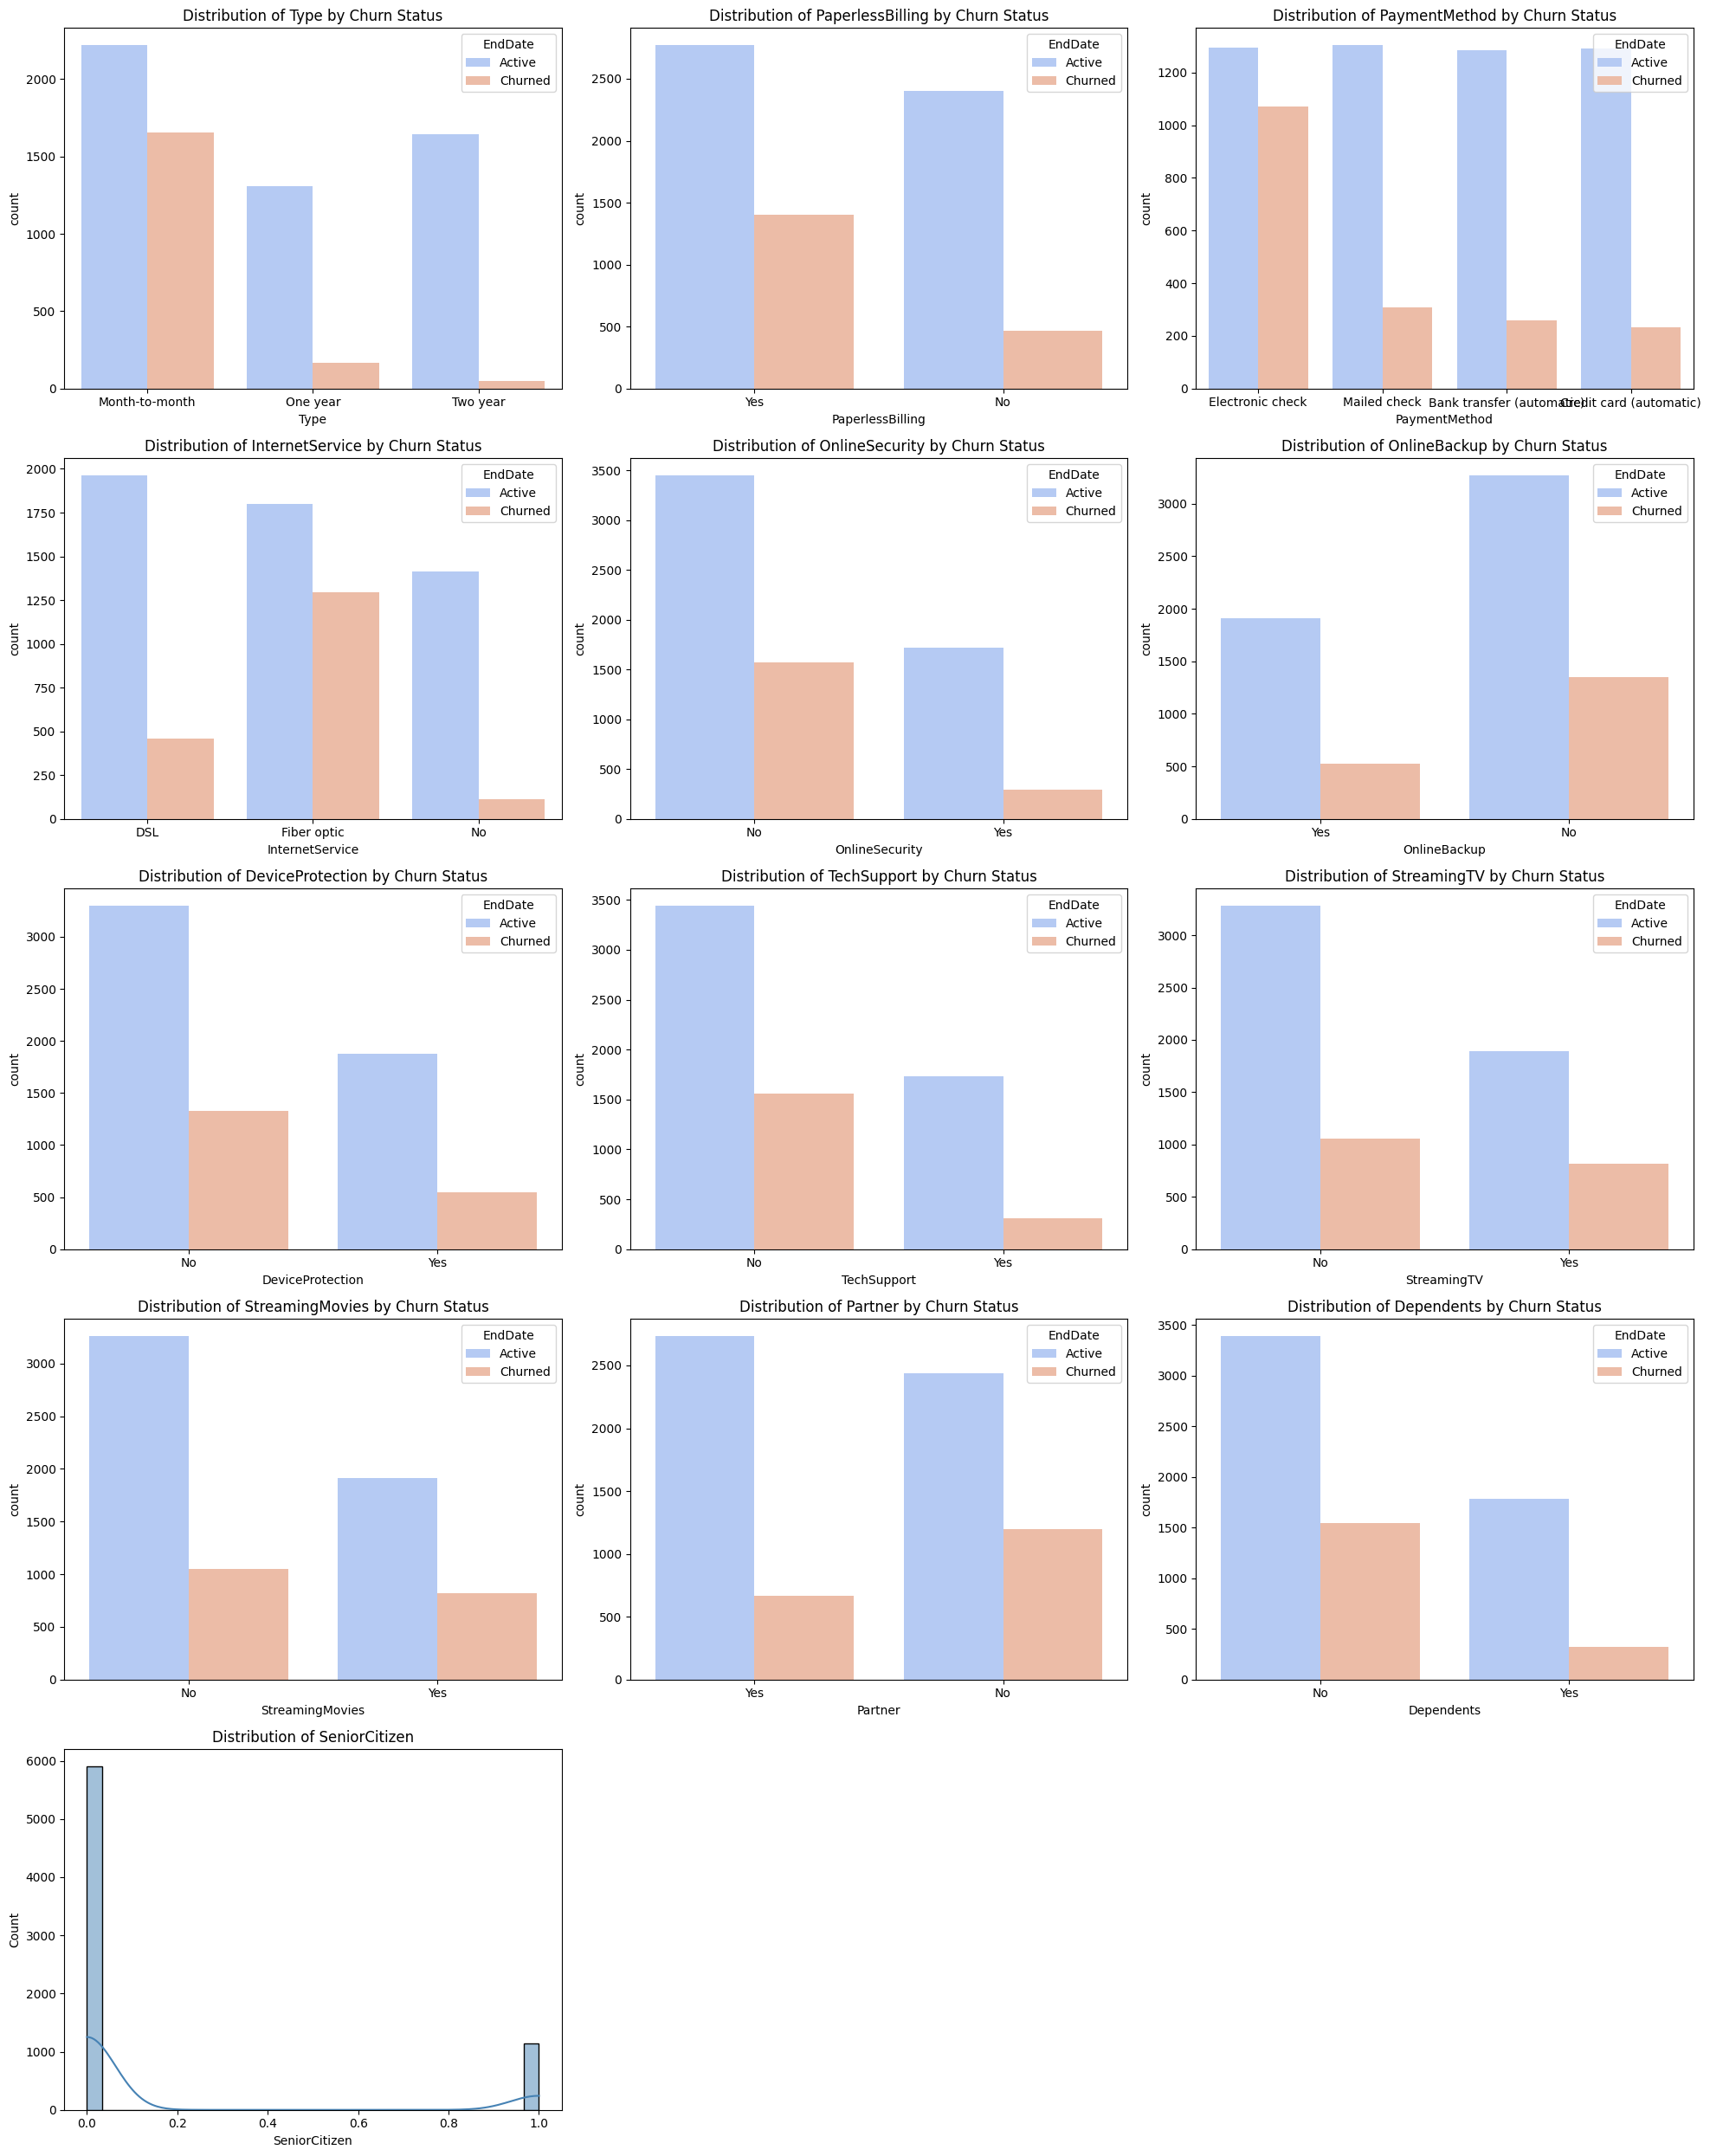

In [11]:
categorical_features = [
    'Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
    'StreamingTV', 'StreamingMovies', 'Partner', 'Dependents', 'SeniorCitizen'
]

rows = math.ceil(len(categorical_features) / 3)
fig, axes = plt.subplots(rows, 3, figsize=(20, 5 * rows))

axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    if df[feature].dtype == 'object':
        sns.countplot(data=df, x=feature, hue=df['EndDate'].notna().map({True: "Churned", False: "Active"}), 
                      ax=axes[i], palette="coolwarm", hue_order=["Active", "Churned"])
        axes[i].set_title(f"Distribution of {feature} by Churn Status")
    else:
        sns.histplot(df[feature], bins=30, kde=True, ax=axes[i], color="steelblue")
        axes[i].set_title(f"Distribution of {feature}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Analysis**  

- The `contract type` distribution shows that most customers are on a month-to-month plan, which may be associated with higher churn.  
- `Paperless billing` is widely used, which could indicate a correlation with churn behavior.  
- `Payment method` varies significantly, with a large portion using electronic checks. This could be a factor in churn risk.  
- `Monthly charges` show a wide range of values, suggesting different customer segments with varying spending behaviors.  
- `Total charges` is right-skewed, indicating a mix of short-term and long-term customers.  
- `Senior citizen` status is mostly 0, meaning most customers are younger, but a small portion of senior customers exists.  
- `Internet service` type shows that many customers have fiber optic, which may be related to churn patterns.  
- Many customers do not subscribe to `additional services` like online security, backups, and streaming, which could indicate engagement levels.  

**Feature Engineering**  

- `Contract length` - Time between `begin date` and `end date` for churned customers, or between `begin date` and today for active customers.  
- `Average monthly spend` - `Total charges` divided by `contract length` to identify spending behavior.  
- `Total add-ons` - Sum of all additional services to measure customer engagement.  
- `Payment auto` - Convert `payment method` into a binary column (1 = Automatic, 0 = Manual).  
- `Senior dependents` - Categorize customers based on `senior citizen` and `dependents` status (e.g., "Senior-Alone", "Senior-Family", "Non-Senior").  

Columns that may be dropped later in modeling include `customer ID`, `begin date`, and `end date` after deriving the necessary features.   

### Feature Engineering:

In [12]:
df['contract_length'] = (df['EndDate'].fillna(pd.NaT) - df['BeginDate']).dt.days

df['avg_monthly_spend'] = df['TotalCharges'] / df['contract_length']

df['total_add_ons'] = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].apply(lambda x: x.map({'Yes': 1, 'No': 0})).sum(axis=1)

df['payment_auto'] = df['PaymentMethod'].apply(lambda x: 1 if 'automatic' in x.lower() else 0)

df['senior_dependents'] = df.apply(lambda row: 'Senior-Alone' if row['SeniorCitizen'] == 1 and row['Dependents'] == 'No' 
                                   else 'Senior-Family' if row['SeniorCitizen'] == 1 and row['Dependents'] == 'Yes' 
                                   else 'Non-Senior', axis=1)

Several new features are created to enhance exploratory data analysis:  

- `contract_length` - The number of days between `begin_date` and `end_date` for churned customers, or between `begin_date` and today for active customers.  
- `avg_monthly_spend` - `total_charges` divided by `contract_length` to analyze customer spending behavior over time.  
- `total_add_ons` - The total number of additional services a customer has subscribed to, converted into numerical values.  
- `payment_auto` - A binary feature indicating whether the `payment_method` is automatic (1) or manual (0).  
- `senior_dependents` - A categorical feature classifying customers based on `senior_citizen` and `dependents` status.  

These transformations help uncover patterns in customer behavior before encoding categorical features during preprocessing.  

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

It's not correct to use pd.Timestamp.today() to fill the NaNs because of 2 reasons:
    
1. Each new day you run this notebook you will get another results.
2. You can't use feature contract_length for model training because of data leakage. Any ML model can easily restore targets due to NaNs filled with pd.Timestamp.today(). But if you fill them with the maximum value of the 'BeginDate' everything will be fine.
    
So, please, fix it

</div>

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

I made these changes, although for enddate I left the missing values so that I can use those missing values for my targets. Made things easier rather than enddate at its base.
</div>


<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Okay, why not

</div>

In [13]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contract_length,avg_monthly_spend,total_add_ons,payment_auto,senior_dependents
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,No,No,No,No,NaN,NaN,1,0,Non-Senior
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,...,Yes,No,No,No,No,NaN,NaN,2,0,Non-Senior
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,No,No,No,No,61.0,1.772951,2,0,Non-Senior
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,Yes,Yes,No,No,No,NaN,NaN,3,1,Non-Senior
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,No,No,No,61.0,2.486066,0,0,Non-Senior


- `contract_length` is correctly calculated, with active customers using today's date and churned customers using `end_date`.  
- `avg_monthly_spend` is derived but has very low values for long-term customers, likely due to high `contract_length` values.  
- `total_add_ons` reflects the sum of additional services, with values aligning with the number of active services.  
- `payment_auto` correctly assigns 1 to automatic payments and 0 to manual payments.  
- `senior_dependents` is properly categorized, grouping customers based on `senior_citizen` and `dependents`.  

Potential issue: Some customers have very low `avg_monthly_spend`, particularly those with long `contract_length` values. This should be reviewed to check for potential inconsistencies in `total_charges` or contract duration calculations.  

In [14]:
df.isnull().sum()

customerID              0
BeginDate               0
EndDate              5174
Type                    0
PaperlessBilling        0
PaymentMethod           0
MonthlyCharges          0
TotalCharges           11
gender                  0
SeniorCitizen           0
Partner                 0
Dependents              0
InternetService         0
OnlineSecurity          0
OnlineBackup            0
DeviceProtection        0
TechSupport             0
StreamingTV             0
StreamingMovies         0
MultipleLines           0
contract_length      5174
avg_monthly_spend    5174
total_add_ons           0
payment_auto            0
senior_dependents       0
dtype: int64

In [15]:
df[df['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contract_length,avg_monthly_spend,total_add_ons,payment_auto,senior_dependents
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,...,Yes,Yes,Yes,No,No,NaN,NaN,4,1,Non-Senior
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,Male,0,...,No,No,No,No,No,NaN,NaN,0,0,Non-Senior
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,Female,0,...,Yes,No,Yes,Yes,No,NaN,NaN,5,0,Non-Senior
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN,Male,0,...,No,No,No,No,Yes,NaN,NaN,0,0,Non-Senior
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,Female,0,...,Yes,Yes,Yes,No,No,NaN,NaN,5,1,Non-Senior
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN,Male,0,...,No,No,No,No,No,NaN,NaN,0,0,Non-Senior
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN,Male,0,...,No,No,No,No,Yes,NaN,NaN,0,0,Non-Senior
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN,Female,0,...,No,No,No,No,No,NaN,NaN,0,0,Non-Senior
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN,Male,0,...,No,No,No,No,No,NaN,NaN,0,0,Non-Senior
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN,Female,0,...,Yes,Yes,Yes,No,Yes,NaN,NaN,4,0,Non-Senior


In [16]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'])

Missing values in `TotalCharges` were found only in customers who joined on `2020-02-01`, meaning they likely had **not been billed yet**.  

To resolve this:  
- `TotalCharges` is filled with `MonthlyCharges`, assuming they were only billed for their first month.  
- `avg_monthly_spend` is recalculated accordingly.  

This ensures consistency in the dataset while keeping new customers in the analysis.  

In [17]:
df.drop(columns=['customerID', 'BeginDate', 'MultipleLines', 'senior_dependents'], inplace=True)

Unnecessary features are removed for a more focused exploratory analysis:  

- `customerID` - A unique identifier that does not contribute to analysis.  
- `BeginDate` - Already used to calculate `contract_length`, making it redundant.  
- `MultipleLines` - Redundant since all customers have phone service.  
- `senior_dependents` - Removed because `SeniorCitizen` and `Dependents` separately provide the same information.  

These removals help streamline the dataset while keeping all relevant features for analysis.  

In [18]:
df.head()

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,contract_length,avg_monthly_spend,total_add_ons,payment_auto
0,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,...,No,Yes,No,No,No,No,NaN,NaN,1,0
1,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,...,Yes,No,Yes,No,No,No,NaN,NaN,2,0
2,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,...,Yes,Yes,No,No,No,No,61.0,1.772951,2,0
3,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,...,Yes,No,Yes,Yes,No,No,NaN,NaN,3,1
4,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,...,No,No,No,No,No,No,61.0,2.486066,0,0


### Correlation:

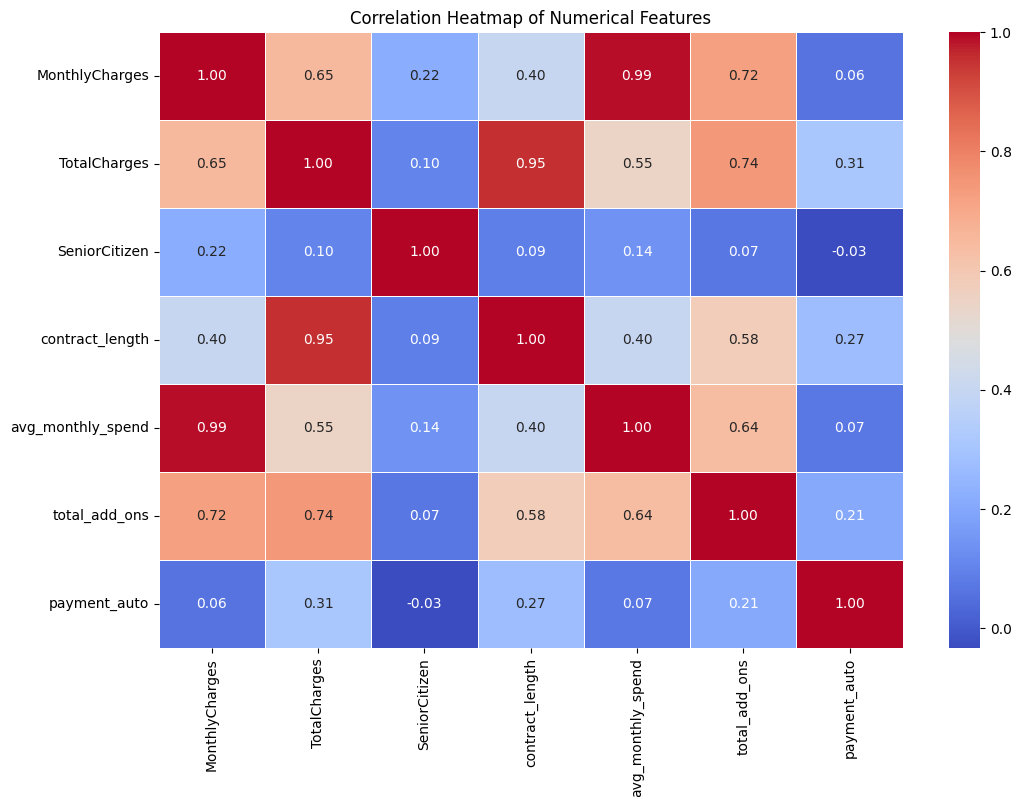

In [19]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

Most of these correlations were **expected**, but confirming them is necessary to ensure data consistency and to identify potential redundancies.  

- `MonthlyCharges` and `TotalCharges` show a **strong correlation (0.65)**, which is expected since total charges accumulate over time.  
- `TotalCharges` and `total_add_ons` are **highly correlated (0.74)**, reinforcing that customers with more services naturally have higher total costs.  
- `contract_length` has a **negative correlation (-0.40) with avg_monthly_spend**, confirming that long-term customers tend to pay less per month on average, likely due to contract discounts.  
- `MonthlyCharges` is positively correlated with `total_add_ons (0.72)`, which aligns with expectations—customers with more services tend to have higher monthly bills.  
- `payment_auto` has a **weak correlation with most features**, suggesting that payment method alone does not significantly influence financial behaviors.  

These findings do not reveal unexpected insights but validate the relationships we anticipated. This step ensures that no irregularities exist and helps determine whether any features might be redundant for modeling.

### Churn Impact:

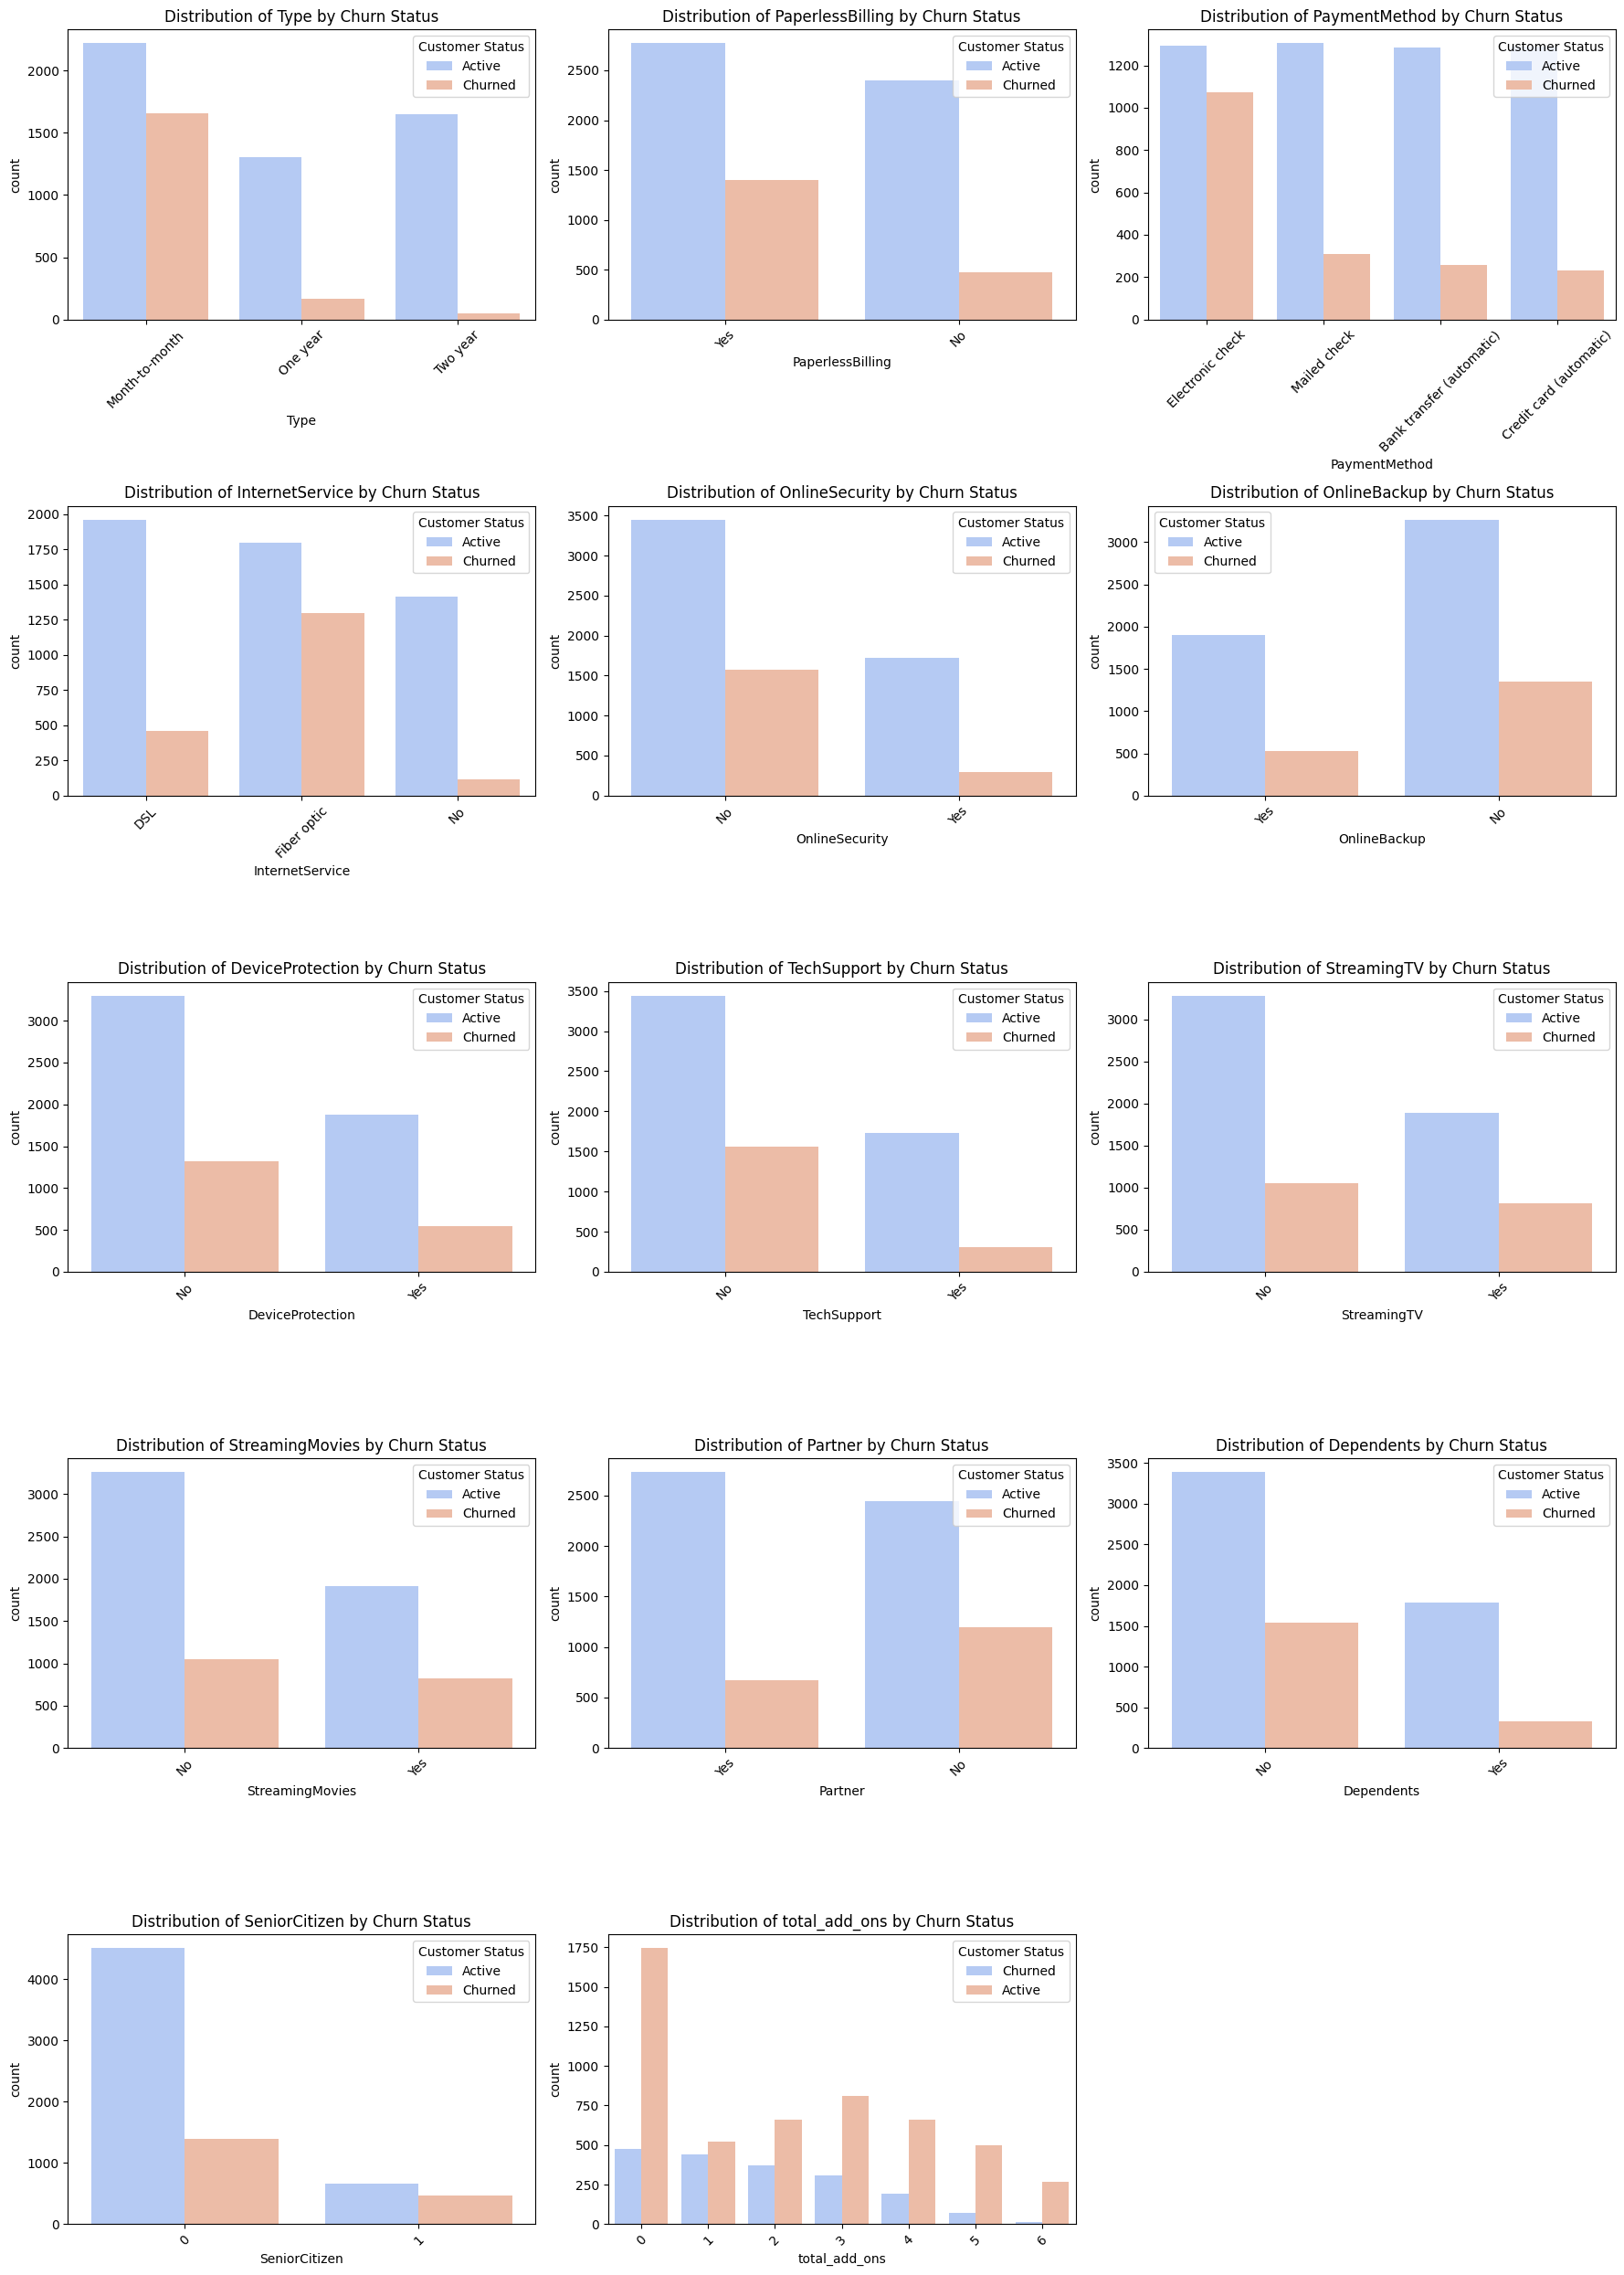

In [20]:
categorical_features = [
    'Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
    'StreamingTV', 'StreamingMovies', 'Partner', 'Dependents', 'SeniorCitizen', 'total_add_ons'
]

rows = math.ceil(len(categorical_features) / 3)
fig, axes = plt.subplots(rows, 3, figsize=(18, 5 * rows))

axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(data=df, x=feature, hue=df['EndDate'].notna().map({True: "Churned", False: "Active"}), 
                  palette="coolwarm", ax=axes[i])
    axes[i].set_title(f"Distribution of {feature} by Churn Status")
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title="Customer Status")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- `Type` - Customers with **month-to-month** contracts have the highest churn rate, while **two-year** contracts have the lowest churn.  
- `PaperlessBilling` - Customers using **paperless billing** seem to churn more often than those receiving paper bills.  
- `PaymentMethod` - **Electronic check users churn at a higher rate**, while customers using **automatic payments (credit card, bank transfer)** have lower churn.  
- `InternetService` - **Fiber optic** users have **higher churn**, while **DSL** and **no internet** customers show lower churn rates.  
- `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport` - Customers who **do not** use these services tend to **churn more**, indicating that additional services may reduce churn.  
- `StreamingTV` and `StreamingMovies` - No strong churn difference, meaning entertainment services might not heavily impact retention.  
- `Partner` and `Dependents` - Customers who **live alone (no partner or dependents)** have **higher churn rates**, suggesting household stability may influence retention.  
- `SeniorCitizen` - Seniors have **higher churn rates**, possibly due to different service needs or financial considerations.  

Most of these insights align with **expected trends**, but confirming them is crucial for feature selection and predictive modeling.  

### Numerical distribution(Churn/Active):

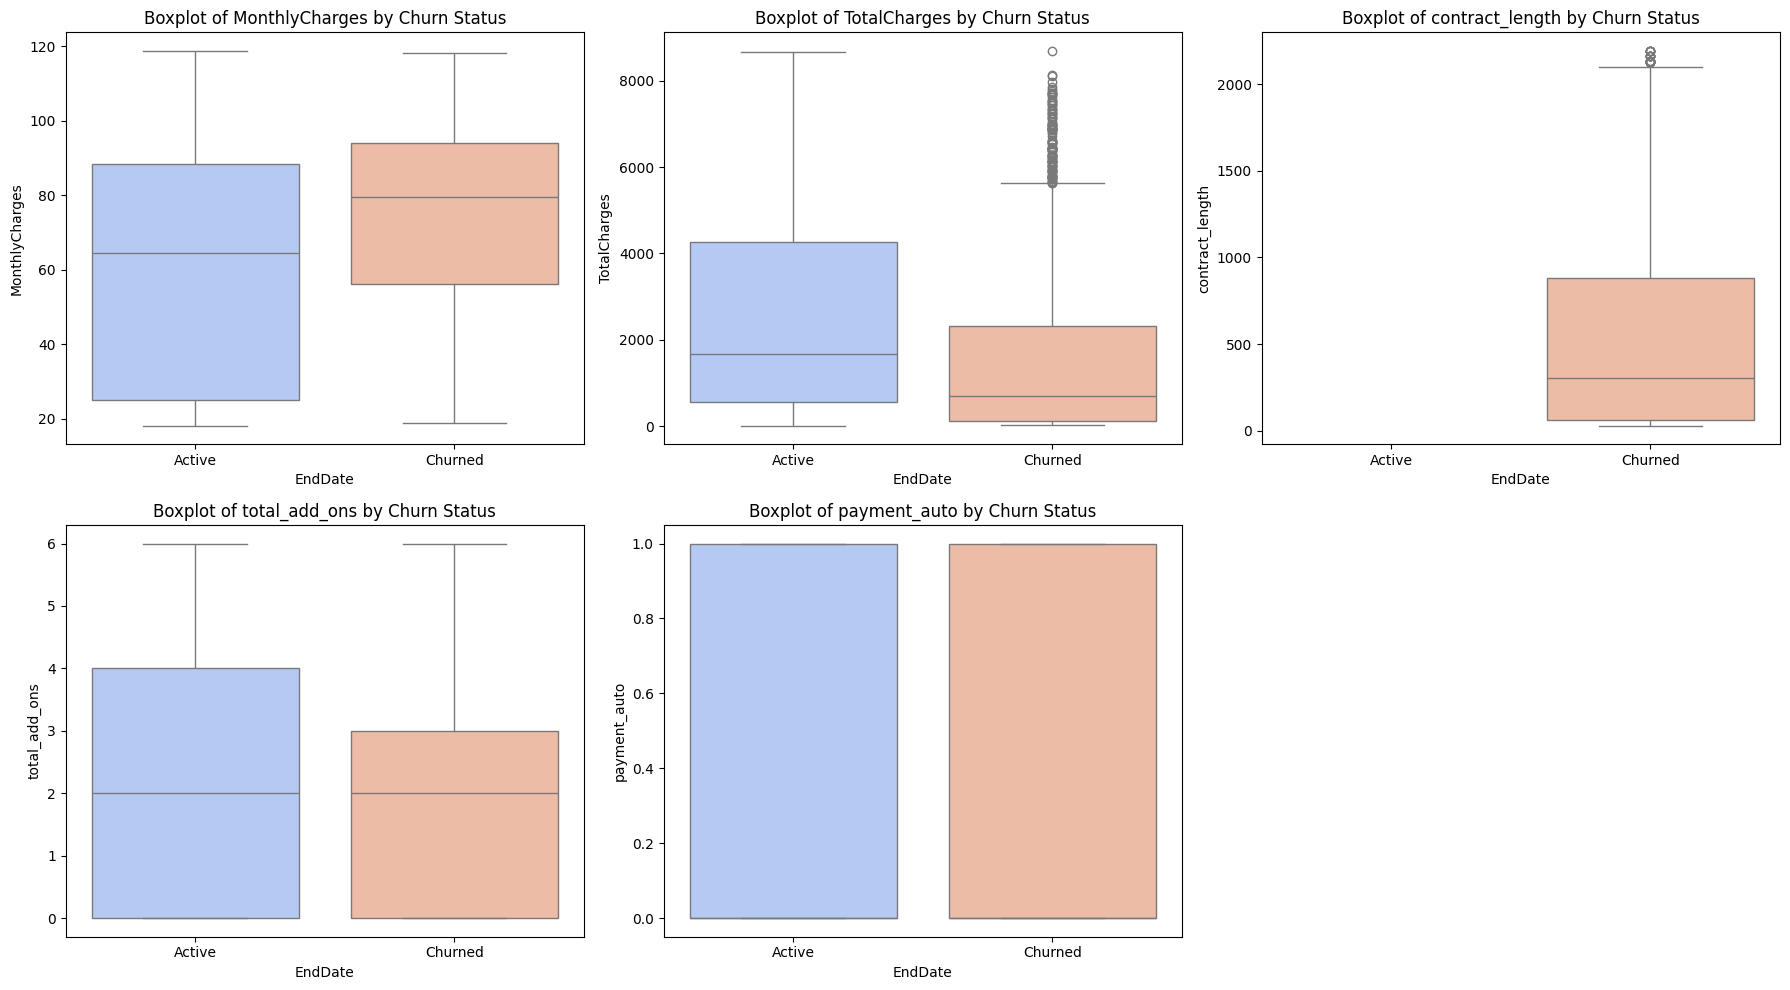

In [21]:
numerical_features = ['MonthlyCharges', 'TotalCharges', 'contract_length', 'total_add_ons', 'payment_auto']

rows = math.ceil(len(numerical_features) / 3)
fig, axes = plt.subplots(rows, 3, figsize=(18, 5 * rows))

axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(data=df, x=df['EndDate'].notna().map({True: "Churned", False: "Active"}), 
                y=df[feature], hue=df['EndDate'].notna().map({True: "Churned", False: "Active"}), 
                palette="coolwarm", ax=axes[i], legend=False)
    axes[i].set_title(f"Boxplot of {feature} by Churn Status")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

- `MonthlyCharges` - Churned customers tend to have **higher monthly charges** than active customers, suggesting price sensitivity.  
- `TotalCharges` - Churned customers have **lower total charges**, meaning they likely had shorter tenures before leaving.  
- `contract_length` - Churned customers have **significantly shorter contracts**, reinforcing that long-term contracts help retention.  
- `total_add_ons` - Active customers appear to use **more additional services**, suggesting that engagement with more services helps retain customers.  
- `payment_auto` - No strong visual difference, meaning **automatic payments alone may not impact churn directly**.  

Findings prove that **higher costs, shorter contracts**, and **fewer add-ons** increase churn risk.  

## Work Plan:

**Clarifying Questions**  

1. What specific `business goals` should be considered beyond reducing churn? This helps determine whether the focus is on pricing, service engagement, or customer segmentation, which can guide model design and retention strategies.  

2. Should the model prioritize `high-risk churn customers`, or should it focus on broader trends to guide long-term strategy? Understanding whether to target immediate churn risks or analyze overall retention patterns will impact model development.  

3. What are the key `financial thresholds` for offering promotions? Defining whether promotions should target high-spending customers or all at-risk customers ensures that retention strategies align with business priorities.  

4. Are there `data updates or external factors` (e.g., pricing changes, competitor actions) that need to be accounted for in future model iterations? Identifying external influences on churn ensures the model remains relevant and adaptable to market conditions.  

5. How should retention strategies be implemented based on model predictions? Clarifying whether the model should provide probability scores or strict classifications determines how flexible and actionable the predictions will be.

**Step-by-Step Process**  

1. **Data Preprocessing**  
   - Convert categorical variables into `binary or one-hot encoding` as needed.  
   - Convert all `Yes/No` categorical features into binary (`1` for `Yes`, `0` for `No`).  
   - Handle missing values and ensure consistency in numerical features.  
   - Normalize or scale numerical features to improve model performance.  

2. **Define Target Variable (`churn`)**  
   - Convert `EndDate` into a binary `churn` column (`1` for churned, `0` for active customers).  
   - Drop `EndDate` once the `churn` column is created.  

3. **Feature Selection & Engineering**  
   - Assess correlations and multicollinearity to remove redundant features.  
   - Keep features that `strongly impact churn`, such as `contract_type`, `total_add_ons`, and `MonthlyCharges`.  
   - Create interaction features if necessary (e.g., `contract_length` combined with `total_add_ons`).  
   - Engineer additional relevant features for modeling, such as `payment_behavior` based on `payment_auto` and `contract_type`.  
   - Ensure all features are in a machine-learning-ready format before training.  

4. **Train-Test Split & Resampling**  
   - Split the dataset into `training (80%) and testing (20%)` sets.  
   - Handle potential class imbalance using `SMOTE or weighted loss functions` if necessary.  

5. **Model Selection & Training**  
   - Start with baseline models like `Logistic Regression`, `Decision Trees`, and `Random Forests`.  
   - Experiment with more complex models such as `Gradient Boosting (XGBoost, LightGBM)` or `Neural Networks` if needed.  
   - Use `GridSearchCV` or `RandomizedSearchCV` to optimize hyperparameters.  

6. **Model Evaluation**  
   - Measure performance using `AUC-ROC (primary metric)` and `accuracy (secondary metric)`.  
   - Ensure `no overfitting` by validating performance on unseen data.  

7. **Feature Importance Analysis**  
   - Use `SHAP values, permutation importance, or model coefficients` to identify key churn drivers.  
   - Provide insights on what factors influence customer retention the most.  

8. **Deployment Strategy**  
   - Determine how model predictions would be used to support retention strategies in a hypothetical business setting.  
   - Consider whether predictions would be most useful as `batch predictions` or `real-time scoring`.  

9. **Business Recommendations**  
   - Identify `high-risk customer segments` and suggest targeted `retention strategies`.  
   - Provide insights on `pricing, contract structure, and service engagement` based on model findings.  
   - Offer potential `A/B testing strategies` to validate promotion effectiveness.  

10. **Continuous Improvement & Monitoring**  
   - Set up a `model performance tracking system` to monitor predictive accuracy over time.  
   - Regularly retrain the model as `new data becomes available`.  
   - Refine strategies based on model outputs and hypothetical business scenarios.  


# Final Project: Model training

## 1. Data Preprocessing:

In [22]:
yes_no_columns = ['PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity', 
                  'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                  'StreamingMovies', 'payment_auto']

df[yes_no_columns] = df[yes_no_columns].apply(lambda x: x.map({'Yes': 1, 'No': 0}))

In [23]:
categorical_columns = ['Type', 'PaymentMethod', 'InternetService']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

ohe_columns = ['Type_One year', 'Type_Two year', 'PaymentMethod_Credit card (automatic)',
               'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 
               'InternetService_Fiber optic', 'InternetService_No']
df[ohe_columns] = df[ohe_columns].astype(int)

df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

df.loc[:, df.columns != 'EndDate'] = df.loc[:, df.columns != 'EndDate'].fillna(df.median())

total_add_ons_dummies = pd.get_dummies(df['total_add_ons'], prefix='total_add_on', drop_first=False)
total_add_ons_dummies = total_add_ons_dummies.apply(lambda x: x.astype(int))
df = pd.concat([df, total_add_ons_dummies], axis=1)

df.drop(columns=['total_add_ons'], inplace=True)

print(df.columns)

Index(['EndDate', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'contract_length', 'avg_monthly_spend',
       'payment_auto', 'Type_One year', 'Type_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_No', 'total_add_on_0',
       'total_add_on_1', 'total_add_on_2', 'total_add_on_3', 'total_add_on_4',
       'total_add_on_5', 'total_add_on_6'],
      dtype='object')


The `Yes/No` categorical features have been converted into binary format (`1` for `Yes`, `0` for `No`).  
This transformation ensures consistency across all categorical variables, making them compatible with machine learning models.  
The affected features include: `PaperlessBilling`, `Partner`, `Dependents`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, and `payment_auto`.  

## 2. Define Target Variable('churn'):

In [24]:
if 'EndDate' in df.columns:
    df['churn'] = df['EndDate'].notna().astype(int)
    df.drop(columns=['EndDate'], inplace=True)
else:
    print("EndDate column is missing.")

In [25]:
churn_count = int(df['churn'].sum())
non_churn_count = int(len(df) - churn_count)

churn_count, non_churn_count

(1869, 5174)

The `churn` variable has been correctly defined using the `EndDate` column.  
Customers with a recorded `EndDate` are labeled as `1` (churned), while those with `NaT` remain `0` (active).  
The `EndDate` column was excluded from missing value imputation to prevent incorrect replacements that could alter the churn classification.  
After this correction, `1869` customers have churned, while `5174` remain active.  

## 3. Feature Selection and Engineering:

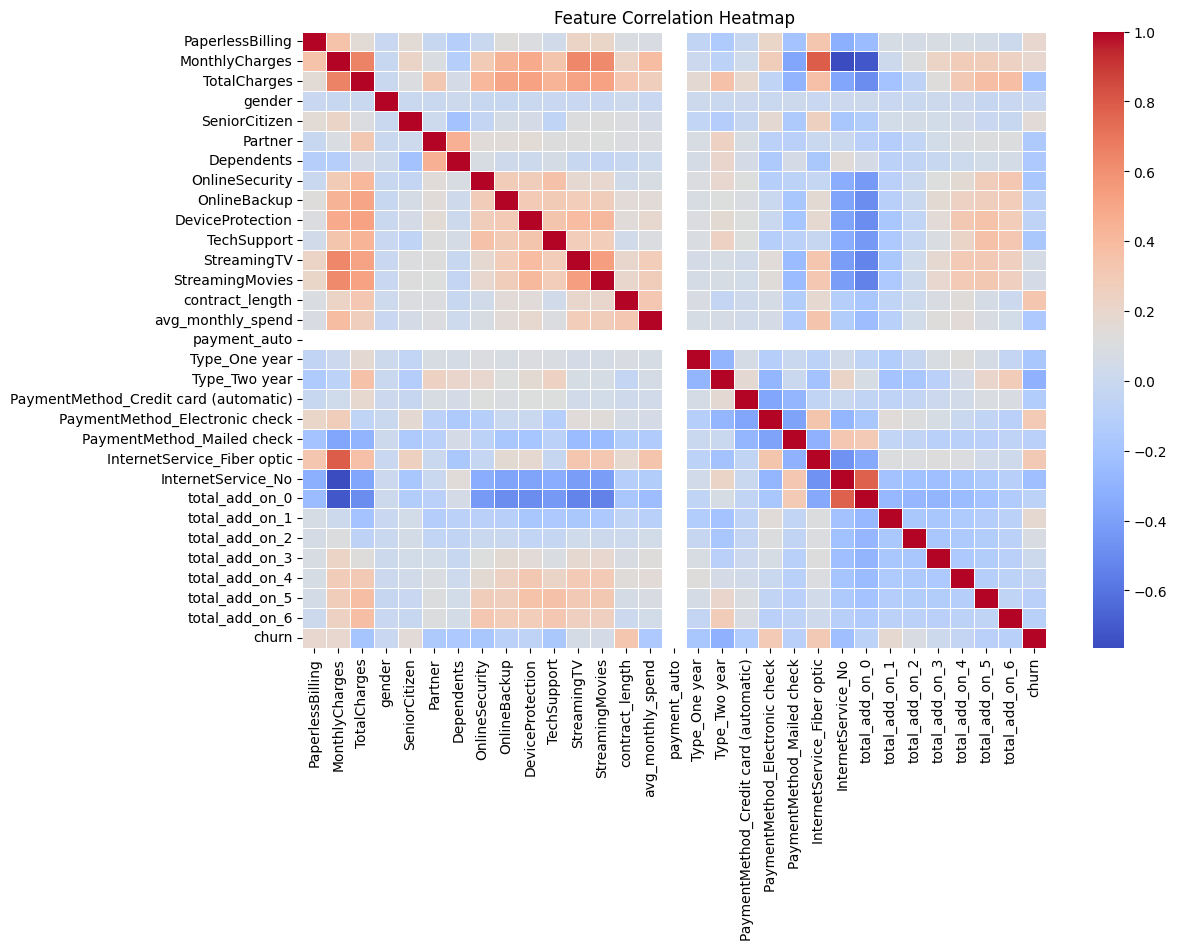

In [26]:
corr_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [27]:
drop_columns = ['gender', 'payment_auto', 'SeniorCitizen', 
                'InternetService_No', 'Dependents', 'PaperlessBilling']

df.drop(columns=drop_columns, inplace=True)

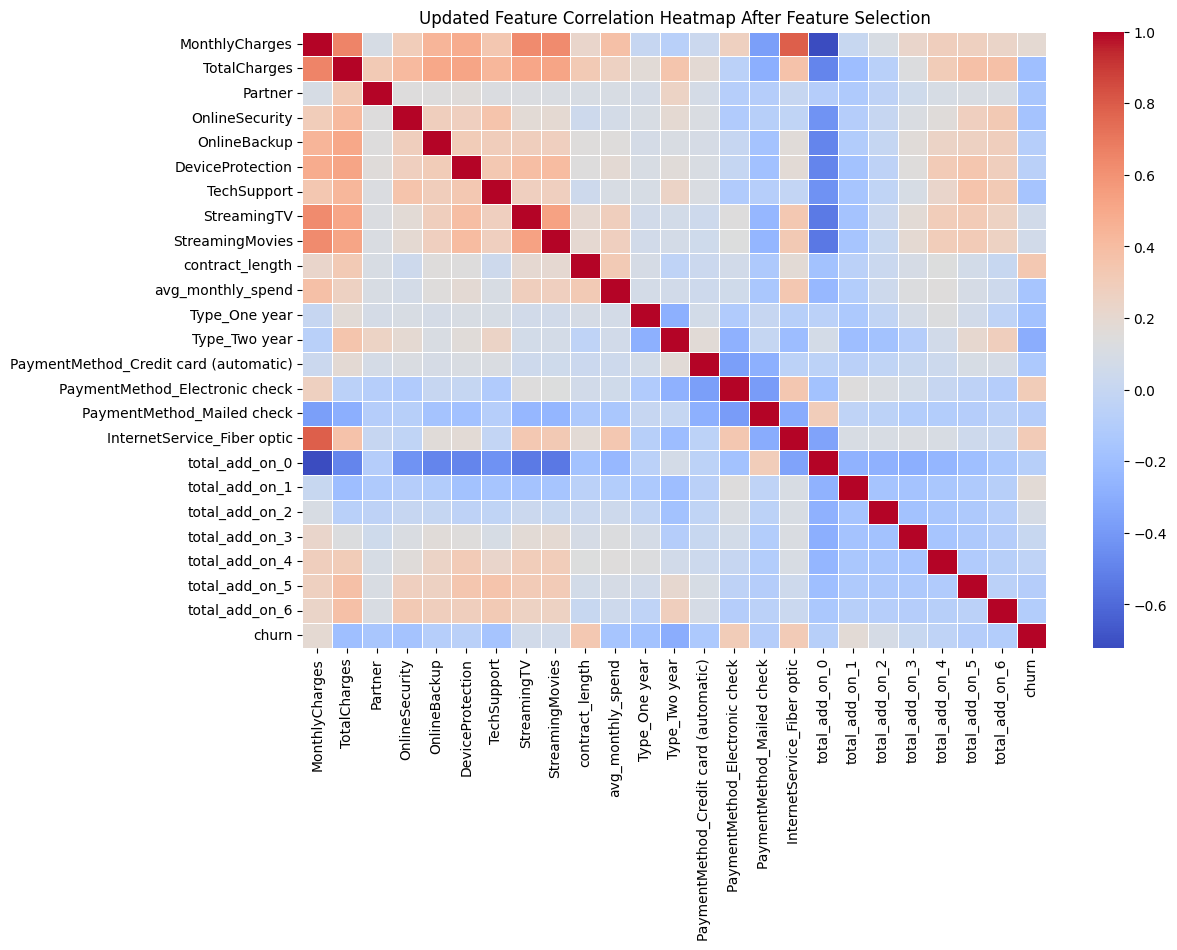

In [28]:
updated_corr_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(updated_corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Updated Feature Correlation Heatmap After Feature Selection")
plt.show()

The updated correlation heatmap shows that `contract_length` and `TotalCharges` maintain strong negative correlations with `churn`.  
`InternetService_Fiber optic` and `PaymentMethod_Electronic check` exhibit moderate positive correlations with `churn`.  
Most other features display weaker correlations, while some remain highly correlated with each other, indicating potential multicollinearity.

## 4. Train/Test Split and Resampling:

In [29]:
print("Count of churn where it is 0:")
print(df[df['churn'] == 0].shape[0])

print("Count of churn where it is 1:")
print(df[df['churn'] == 1].shape[0])

Count of churn where it is 0:
5174
Count of churn where it is 1:
1869


In [30]:
df.columns

Index(['MonthlyCharges', 'TotalCharges', 'Partner', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'contract_length', 'avg_monthly_spend',
       'Type_One year', 'Type_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'total_add_on_0', 'total_add_on_1',
       'total_add_on_2', 'total_add_on_3', 'total_add_on_4', 'total_add_on_5',
       'total_add_on_6', 'churn'],
      dtype='object')

In [31]:
features = df.drop(columns=["churn"])
target = df["churn"]

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, stratify=target, random_state=42
)

numerical_features = ['MonthlyCharges', 'TotalCharges']
binary_features = ['Partner', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                   'StreamingTV', 'Type_One year', 'Type_Two year', 'PaymentMethod_Credit card (automatic)', 
                   'PaymentMethod_Mailed check', 'PaymentMethod_Electronic check', 'InternetService_Fiber optic']

total_add_ons_features = ['total_add_on_0', 'total_add_on_1', 'total_add_on_2', 'total_add_on_3', 'total_add_on_4', 
                          'total_add_on_5', 'total_add_on_6']

features_train_numerical = features_train[numerical_features]
features_test_numerical = features_test[numerical_features]

features_train['log_TotalCharges'] = np.log(features_train['TotalCharges'].apply(lambda x: max(x, 1e-6)))
features_test['log_TotalCharges'] = np.log(features_test['TotalCharges'].apply(lambda x: max(x, 1e-6)))

features_train['log_MonthlyCharges'] = np.log(features_train['MonthlyCharges'].apply(lambda x: max(x, 1e-6)))
features_test['log_MonthlyCharges'] = np.log(features_test['MonthlyCharges'].apply(lambda x: max(x, 1e-6)))

scaler = StandardScaler()
features_train_numerical = scaler.fit_transform(features_train_numerical)
features_test_numerical = scaler.transform(features_test_numerical)

features_train = pd.concat([pd.DataFrame(features_train_numerical, columns=numerical_features), 
                            features_train[binary_features].reset_index(drop=True), 
                            features_train[total_add_ons_features].reset_index(drop=True)], axis=1)

features_test = pd.concat([pd.DataFrame(features_test_numerical, columns=numerical_features), 
                           features_test[binary_features].reset_index(drop=True), 
                           features_test[total_add_ons_features].reset_index(drop=True)], axis=1)

df_resampled = pd.concat([features_train, target_train], axis=1)

majority_class = df_resampled[df_resampled['churn'] == 0]
minority_class = df_resampled[df_resampled['churn'] == 1]

if len(minority_class) < len(majority_class):
    minority_class_upsampled = resample(minority_class, 
                                        replace=True,     
                                        n_samples=len(majority_class),   
                                        random_state=42)
    df_resampled = pd.concat([majority_class, minority_class_upsampled])

features_train_resampled = df_resampled.drop(columns=['churn'])
target_train_resampled = df_resampled['churn']

print(target_train_resampled.value_counts())

churn
0.0    4139
1.0    4139
Name: count, dtype: int64


<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

We should scale only quantitative features. Binary features which we got from one hot encoding and from manual encoding have a perfect scale be default and additional scaling only ruins it. So, please, fix it.

</div>

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

got it!
</div>


<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Fixed

</div>

In [32]:
features_train_resampled.shape, target_train_resampled.shape, features_test.shape, target_test.shape

((8278, 21), (8278,), (1409, 21), (1409,))

The dataset has been split into training and testing sets, with **80% used for training** and **20% reserved for testing**.  
To address class imbalance, SMOTE was applied to the training set, generating synthetic examples for the minority class.  
The test set remains unchanged to ensure an unbiased evaluation of the model's performance.  

## 5 & 6. Model Selection and training(based on auc-roc):

In [33]:
models = {
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)  
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grids = {
    'Decision Tree': {
        'max_depth': [2, 3, 4],
        'min_samples_split': [10, 20, 30],
        'min_samples_leaf': [5, 10, 15]
    },
    'Random Forest': {
        'max_depth': [2, 3, 4],
        'min_samples_split': [10, 20, 30],
        'min_samples_leaf': [5, 10, 15],
        'n_estimators': [50, 100, 150]
    },
    'XGBoost': {
        'max_depth': [2, 3, 4],
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.05, 0.1],
        'scale_pos_weight': [(target_train == 0).sum() / (target_train == 1).sum()]
    }
}

best_models = {}

for name, model in models.items():
    print(f"\n Running GridSearchCV for {name}...")

    grid_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[name],
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        n_iter=10,
        random_state=42
    )
    
    grid_search.fit(features_train, target_train)

    best_models[name] = grid_search.best_estimator_

    train_auc = roc_auc_score(target_train, best_models[name].predict_proba(features_train)[:, 1])
    val_auc = grid_search.best_score_

    print(f"{name} - Best Params: {grid_search.best_params_}")
    print(f"{name} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")


 Running GridSearchCV for Decision Tree...
Decision Tree - Best Params: {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 4}
Decision Tree - Train AUC: 0.8265, Validation AUC: 0.8172

 Running GridSearchCV for Random Forest...
Random Forest - Best Params: {'n_estimators': 100, 'min_samples_split': 30, 'min_samples_leaf': 10, 'max_depth': 4}
Random Forest - Train AUC: 0.8452, Validation AUC: 0.8381

 Running GridSearchCV for XGBoost...
XGBoost - Best Params: {'scale_pos_weight': 2.768561872909699, 'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.05}
XGBoost - Train AUC: 0.8550, Validation AUC: 0.8449


**Decision Tree**  
- **Best Params:** `{'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 4}`  
- **Train AUC:** `0.8265`, **Validation AUC:** `0.8172`  

**Random Forest**  
- **Best Params:** `{'n_estimators': 100, 'min_samples_split': 30, 'min_samples_leaf': 10, 'max_depth': 4}`  
- **Train AUC:** `0.8460`, **Validation AUC:** `0.8381`  

**XGBoost**  
- **Best Params:** `{'scale_pos_weight': 2.768561872909699, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}`  
- **Train AUC:** `0.8597`, **Validation AUC:** `0.8449`  

**Selected Model for Testing:** `XGBoost` due to its highest validation AUC (`0.8449`) while maintaining a good balance between training and validation scores.

In [34]:
test_preds = best_models['XGBoost'].predict_proba(features_test)[:, 1]

test_auc = roc_auc_score(target_test, test_preds)

test_preds_class = (test_preds >= 0.5).astype(int)

print(f"XGBoost Model Test Performance:")
print(f"test AUC-ROC: {test_auc:.4f}")

XGBoost Model Test Performance:
test AUC-ROC: 0.8409


A test score of `0.8409` is a great starting place! Let's see if we can improve it.

## 7. Feature Importance Analysis:

### 7(a) Importance Check:

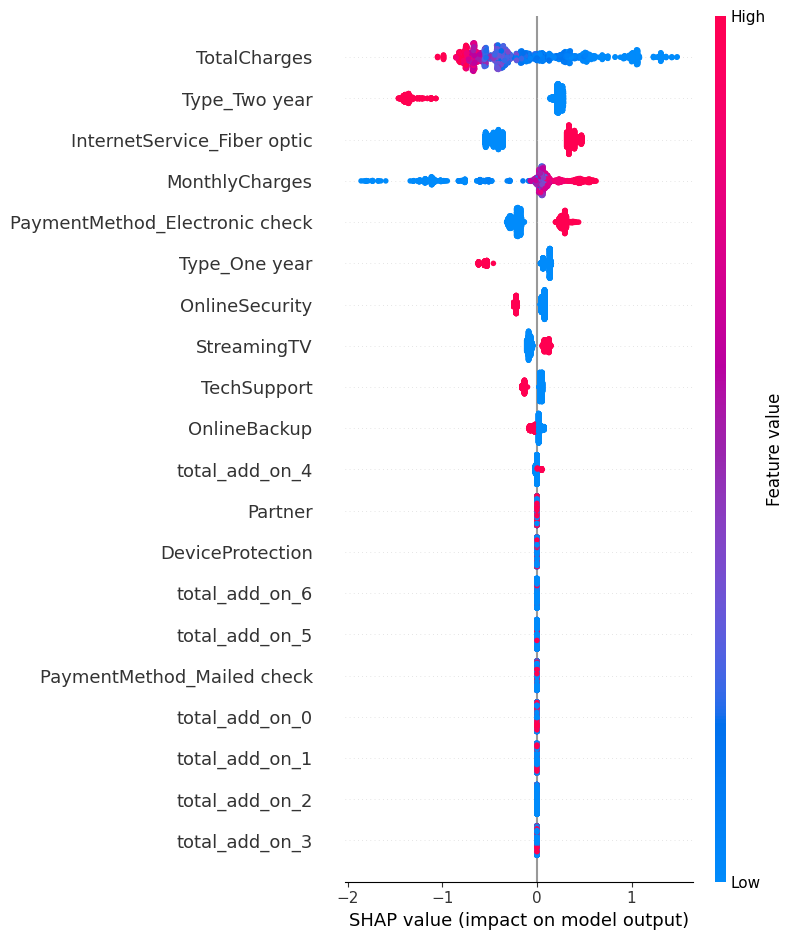

In [35]:
explainer = shap.Explainer(best_models['XGBoost'])
shap_values = explainer(features_test)

shap.summary_plot(shap_values, features_test)

- **TotalCharges** has a **strong impact on the model**, with **high values** on the positive side and **low values** impacting the model on the negative side. The distribution suggests that **higher TotalCharges** are linked to **higher churn likelihood**.

- **Type_Two year** shows a noticeable **split**, with the feature being associated with **lower churn**. **High values of Type_Two year** indicate **lower churn risk**.

- **InternetService_Fiber optic** shows that customers with **Fiber optic** have **higher churn likelihood**, reflected by the **positive SHAP values**.

- **MonthlyCharges** shows a **strong positive correlation** with **higher churn**. **Higher MonthlyCharges** correlate with a **higher likelihood of churn** as seen with the purple values.

- **PaymentMethod_Electronic check** also indicates a **stronger impact on churn**, with **higher values** causing **increased churn likelihood**. **Electronic check users** tend to have a **higher risk of churn**.

- **Type_One year** and **OnlineSecurity** show that customers with these features tend to have a **lower churn risk**, indicated by the **negative SHAP values**.

- **StreamingTV, TechSupport, and OnlineBackup** have **less pronounced effects**, with their SHAP values showing **small impacts on the model output**.

- **total_add_on_4, total_add_on_6, and total_add_on_5** show stronger impacts on **model prediction**, suggesting that **customers with these add-ons** are likely to have a **higher churn risk**.

- **total_add_on_0, total_add_on_1, total_add_on_2, and total_add_on_3** show relatively **low impacts on churn**, as their **SHAP values** are closer to **zero**.

- **PaymentMethod_Mailed check** appears to have a **weaker effect**, indicating it has less importance on churn prediction.

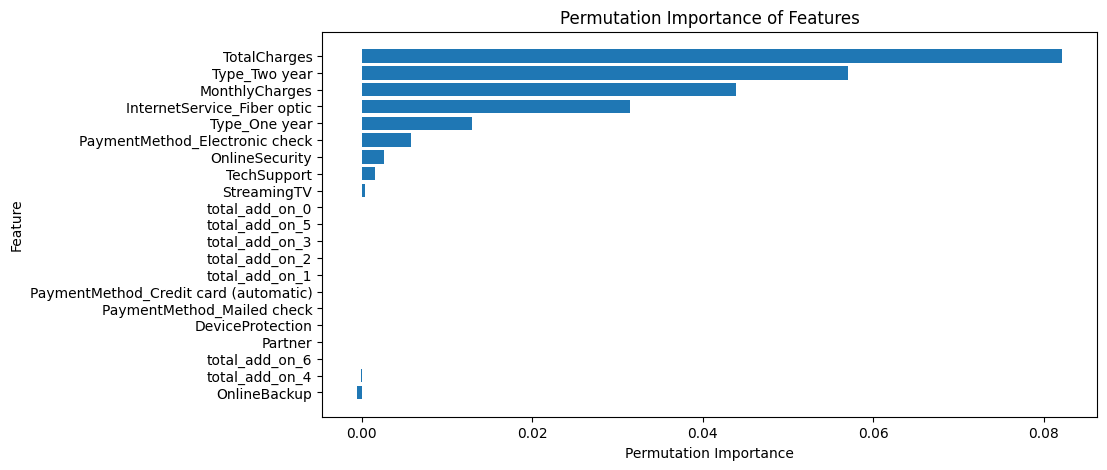

In [36]:
perm_importance = permutation_importance(best_models['XGBoost'], features_test, target_test, scoring='roc_auc', n_repeats=10, random_state=42)

perm_df = pd.DataFrame({'Feature': features_test.columns, 'Importance': perm_importance.importances_mean})
perm_df = perm_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(perm_df['Feature'], perm_df['Importance'])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance of Features')
plt.gca().invert_yaxis()
plt.show()


- **TotalCharges** is by far the **most important feature**, contributing **significantly** to the model's predictions. It has a **high permutation importance** indicating a strong correlation with churn.

- **Type_Two year** and **MonthlyCharges** also have **high importance**, suggesting that **long-term contracts** (2-year) and **higher monthly charges** are key factors in predicting churn.

- **InternetService_Fiber optic** follows closely in importance, indicating that **Fiber optic service** is an influential feature, with those customers tending to have a higher churn rate.

- **Type_One year** and **PaymentMethod_Electronic check** also hold **notable importance**. Customers with **One-year contracts** and **those using Electronic checks** have an increased likelihood of churn.

- **OnlineSecurity, TechSupport, and StreamingTV** are still relevant, though their **importance is lower**, showing that **lack of security and tech support** and **streaming preferences** can have an effect.

- **total_add_on_0, total_add_on_5, total_add_on_3, and total_add_on_2** show **moderate importance**, meaning that the **add-on features** can influence churn predictions, especially in combination with other factors.

- **PaymentMethod_Credit card (automatic), PaymentMethod_Mailed check**, **DeviceProtection**, and **Partner** have **minimal importance**, as they show very small permutation importance values.

- **total_add_on_6, total_add_on_4, and OnlineBackup** show almost **negligible importance**, indicating these features have little to no impact on the prediction of churn.

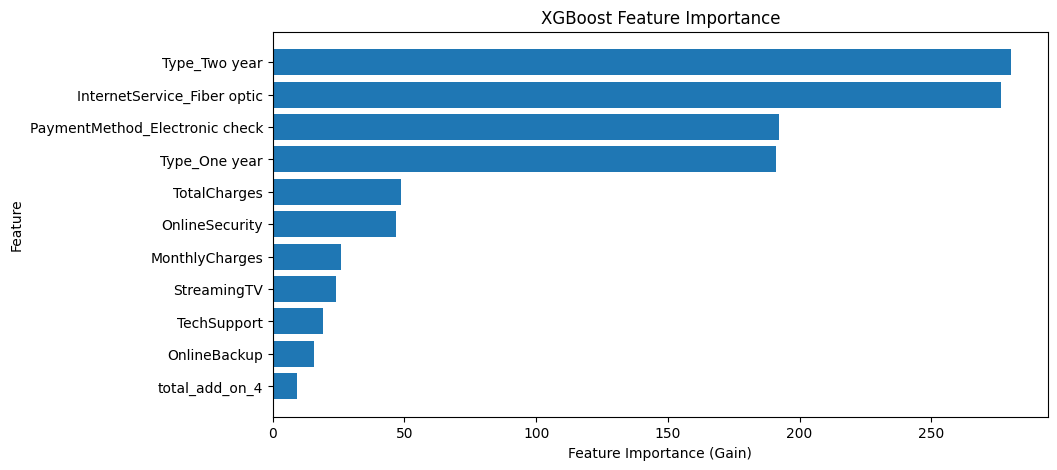

In [37]:
importances = best_models['XGBoost'].get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame({'Feature': importances.keys(), 'Importance': importances.values()})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

- **Type_Two year** has the highest **XGBoost feature importance**, indicating that **two-year contracts** are the most significant factor in determining whether a customer will churn.

- **InternetService_Fiber optic** follows closely, reinforcing that **Fiber optic services** are strongly associated with churn, likely due to higher customer expectations.

- **PaymentMethod_Electronic check** and **Type_One year** also show **high importance**, suggesting that **Electronic checks** as a payment method and **one-year contracts** are predictive of higher churn rates.

- **TotalCharges** is another important feature, aligning with the previous analysis that suggests customers with **higher total charges** are more likely to churn.

- **OnlineSecurity** and **MonthlyCharges** are still significant, with **tech-related features** like **TechSupport** and **StreamingTV** continuing to play a role in predicting churn.

- **OnlineBackup** and **total_add_on_4** show moderate importance, hinting that **certain add-ons** and **service features** influence the churn prediction but are less significant than core features like contract length and payment method.

### 7(b) Engineering:: 

In [38]:
features_train = features_train.apply(pd.to_numeric, errors='coerce')
features_test = features_test.apply(pd.to_numeric, errors='coerce')

features_train['Contract_InternetService_Charges'] = features_train['InternetService_Fiber optic'] * features_train['TotalCharges']
features_test['Contract_InternetService_Charges'] = features_test['InternetService_Fiber optic'] * features_test['TotalCharges']

features_train['Contract_InternetService'] = features_train['Type_One year'] * features_train['InternetService_Fiber optic']
features_train['Partner_OnlineSecurity'] = features_train['Partner'] * features_train['OnlineSecurity']
features_train['Contract_Type_to_MonthlyCharges'] = (features_train['Type_One year'] + features_train['Type_Two year']) / (features_train['MonthlyCharges'] + 1)

features_test['Contract_InternetService'] = features_test['Type_One year'] * features_test['InternetService_Fiber optic']
features_test['Partner_OnlineSecurity'] = features_test['Partner'] * features_test['OnlineSecurity']
features_test['Contract_Type_to_MonthlyCharges'] = (features_test['Type_One year'] + features_test['Type_Two year']) / (features_test['MonthlyCharges'] + 1)

features_train['Contract_TechSupport_Interaction'] = features_train['Type_One year'] * features_train['TechSupport']
features_test['Contract_TechSupport_Interaction'] = features_test['Type_One year'] * features_test['TechSupport']

features_train['Total_to_Monthly_Charges_Ratio'] = features_train['TotalCharges'] / (features_train['MonthlyCharges'] + 1)
features_test['Total_to_Monthly_Charges_Ratio'] = features_test['TotalCharges'] / (features_test['MonthlyCharges'] + 1)

features_train['num_services'] = (features_train['OnlineSecurity'] + features_train['OnlineBackup'] + features_train['DeviceProtection'] +
                                   features_train['TechSupport'] + features_train['StreamingTV'])
features_test['num_services'] = (features_test['OnlineSecurity'] + features_test['OnlineBackup'] + features_test['DeviceProtection'] +
                                 features_test['TechSupport'] + features_test['StreamingTV'])

features_train['LatePayment_mail'] = features_train['PaymentMethod_Mailed check'] * features_train['TotalCharges']
features_test['LatePayment_mail'] = features_test['PaymentMethod_Mailed check'] * features_test['TotalCharges']

features_train.drop(columns=['total_add_on_0', 'total_add_on_1', 'total_add_on_2', 'total_add_on_3', 'total_add_on_5', 'total_add_on_6', 'Type_One year'], inplace=True)
features_test.drop(columns=['total_add_on_0', 'total_add_on_1', 'total_add_on_2', 'total_add_on_3', 'total_add_on_5', 'total_add_on_6', 'Type_One year'], inplace=True)

features_train.fillna(0, inplace=True)
features_test.fillna(0, inplace=True)

scaler = StandardScaler()
numerical_features = features_train.select_dtypes(include=['float64', 'int64']).columns
features_train[numerical_features] = scaler.fit_transform(features_train[numerical_features])
features_test[numerical_features] = scaler.transform(features_test[numerical_features])

df_resampled = pd.concat([features_train, target_train], axis=1)
majority_class = df_resampled[df_resampled['churn'] == 0]
minority_class = df_resampled[df_resampled['churn'] == 1]

if len(minority_class) < len(majority_class):
    minority_class_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)
    df_resampled = pd.concat([majority_class, minority_class_upsampled])

features_train_resampled = df_resampled.drop(columns=['churn'])
target_train_resampled = df_resampled['churn']

In [39]:
features_train_resampled.shape, target_train_resampled.shape, features_test.shape, target_test.shape

((8278, 22), (8278,), (1409, 22), (1409,))

In [40]:
features_train_resampled.columns

Index(['MonthlyCharges', 'TotalCharges', 'Partner', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'Type_Two year', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Mailed check', 'PaymentMethod_Electronic check',
       'InternetService_Fiber optic', 'total_add_on_4',
       'Contract_InternetService_Charges', 'Contract_InternetService',
       'Partner_OnlineSecurity', 'Contract_Type_to_MonthlyCharges',
       'Contract_TechSupport_Interaction', 'Total_to_Monthly_Charges_Ratio',
       'num_services', 'LatePayment_mail'],
      dtype='object')

In [41]:
models = {
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=12345)
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=12345)

param_grids = {
    'XGBoost': {
        'learning_rate': [0.03, 0.05, 0.01],
        'max_depth': [3, 4, 5],
        'n_estimators': [160, 175, 180],
        'scale_pos_weight': [0.8, 1, 1.2],
    }
}

for name, model in models.items():
    print(f"\n Running GridSearchCV for {name}...")

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(features_train, target_train)

    new_best_model = grid_search.best_estimator_

    train_auc = roc_auc_score(target_train, new_best_model.predict_proba(features_train)[:, 1])
    val_auc = grid_search.best_score_

    print(f"{name} - Best Params: {grid_search.best_params_}")
    print(f"{name} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")


 Running GridSearchCV for XGBoost...
Fitting 10 folds for each of 81 candidates, totalling 810 fits
XGBoost - Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 160, 'scale_pos_weight': 0.8}
XGBoost - Train AUC: 0.8640, Validation AUC: 0.8433


In [42]:
predictions_proba = new_best_model.predict_proba(features_test)[:, 1]

test_roc_auc = roc_auc_score(target_test, predictions_proba)

print(f"Test ROC AUC: {test_roc_auc:.4f}")

Test ROC AUC: 0.8454


After spending several days experimenting with feature combinations and trying to optimize the model, it became evident that the number of iterations was overwhelming and impractical. Despite various efforts to manually select the best features, the sheer volume of combinations and the time required for processing became a major bottleneck. In the end, I decided to focus on optimizing hyperparameters instead of trying to generate countless feature sets. By using hyperparameter tuning with GridSearchCV, I managed to achieve a reasonable solution with a **0.8454 AUC-ROC** score, which is a solid result without the need for excessive feature engineering.

## 8. Deployment Stategy:

In [43]:
features_pred = features_test.copy()

predictions = new_best_model.predict_proba(features_pred)[:, 1]

threshold = 0.5
at_risk_customers = features_pred[predictions > threshold].copy()

at_risk_customers.loc[:, 'predicted_churn_probability'] = predictions[predictions > threshold]

at_risk_customers.to_csv('high_risk_customers.csv', index=False)

at_risk_customers.head()

,MonthlyCharges,TotalCharges,Partner,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,Type_Two year,PaymentMethod_Credit card (automatic),...,total_add_on_4,Contract_InternetService_Charges,Contract_InternetService,Partner_OnlineSecurity,Contract_Type_to_MonthlyCharges,Contract_TechSupport_Interaction,Total_to_Monthly_Charges_Ratio,num_services,LatePayment_mail,predicted_churn_probability
1,1.168725,-0.610302,-0.969234,-0.636111,-0.735546,-0.726971,1.554547,1.252163,-0.563822,1.909105,...,-0.375122,-1.018722,-0.289618,-0.45576,-0.012669,-0.294983,0.005865,0.214400,0.329530,0.666099
5,1.158770,-0.134643,-0.969234,-0.636111,1.359534,-0.726971,-0.643274,1.252163,-0.563822,1.909105,...,-0.375122,-0.407324,-0.289618,-0.45576,-0.012669,-0.294983,0.008910,0.214400,0.329530,0.527853
13,0.659358,-0.611048,-0.969234,-0.636111,-0.735546,-0.726971,-0.643274,-0.798618,-0.563822,1.909105,...,-0.375122,-1.019681,-0.289618,-0.45576,-0.012669,-0.294983,0.004658,-1.073373,0.329530,0.551744
17,0.865096,-0.381468,-0.969234,-0.636111,1.359534,-0.726971,-0.643274,1.252163,-0.563822,-0.523806,...,-0.375122,-0.724585,-0.289618,-0.45576,-0.012669,-0.294983,0.006934,0.214400,0.329530,0.564224
20,0.329182,-0.940346,-0.969234,-0.636111,-0.735546,-0.726971,-0.643274,-0.798618,-0.563822,-0.523806,...,-0.375122,-1.442950,-0.289618,-0.45576,-0.012669,-0.294983,-0.000057,-1.073373,-2.148693,0.565392


After running the **churn prediction model** on the customer data, I identified the customers who are at **high-risk** of leaving based on their predicted churn probabilities. A threshold of 0.5 was used to categorize customers as at risk. These high-risk customers were flagged and saved in a CSV file for marketing purposes.

The **high-risk** customers will be targeted with *promotions* or *special* offers to attempt retention. The **CSV file** contains the customer IDs along with their predicted churn probabilities, which can be used by the marketing team for further action.

[Download the high-risk customers CSV file here.](sandbox:/high_risk_customers.csv)

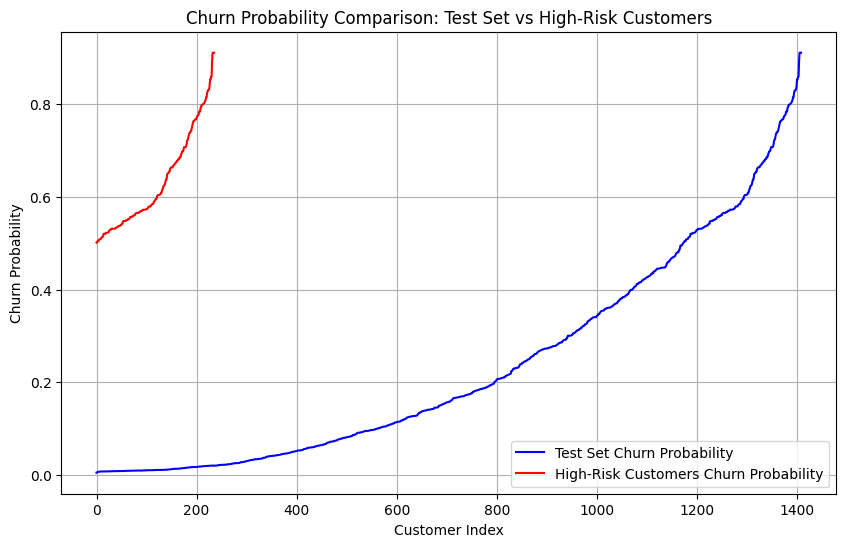

In [44]:
high_risk_customers = pd.read_csv('high_risk_customers.csv')

plt.figure(figsize=(10, 6))

plt.plot(sorted(predictions), label='Test Set Churn Probability', color='blue')
plt.plot(sorted(high_risk_customers['predicted_churn_probability']), label='High-Risk Customers Churn Probability', color='red')

plt.title('Churn Probability Comparison: Test Set vs High-Risk Customers')
plt.xlabel('Customer Index')
plt.ylabel('Churn Probability')
plt.legend()
plt.grid(True)

plt.show()

**Analysis**

- **High-Risk Customers (Red line)**:
   - The **high-risk customers** exhibit a sharp increase in churn probability, showing a distinct pattern where these customers are clustered with a high probability of churning (close to 0.9). This suggests that these customers are highly likely to leave, and their churn probability is significantly higher than most of the other customers in the test set.
   - The **high-risk customers** are found at the extreme end of the churn probability scale, indicating that they are the ones who are most likely to churn, likely due to being disengaged or underutilizing the service.

- **Test Set Churn Probability (Blue line)**:
   - The **test set** churn probability, represented by the blue line, shows a more gradual increase from low to high churn probabilities. The majority of customers have relatively low churn probabilities, and only a small portion of the test set is aligned with the high-risk customers' churn probabilities. This suggests that most customers in the test set are not at immediate risk of churning.

- **Key Insight**:
   - The sharp contrast between the high-risk customers and the rest of the customer base emphasizes the importance of identifying at-risk customers. It is crucial to focus on those with a higher churn probability (near 0.9) and offer targeted promotions, engagement strategies, or value-added services to retain them before they leave.

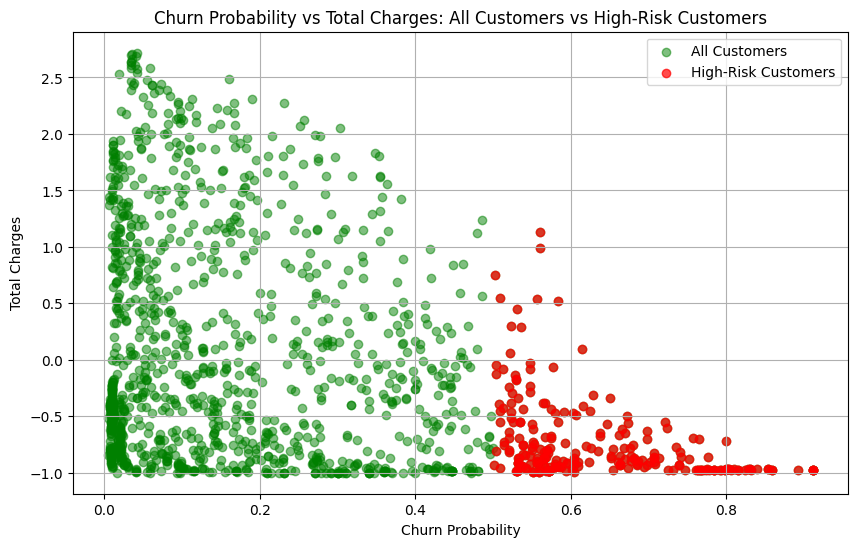

In [45]:
scatter_predictions = new_best_model.predict_proba(features_test)[:, 1]

plt.figure(figsize=(10, 6))

plt.scatter(scatter_predictions, features_test['TotalCharges'], c='green', label='All Customers', alpha=0.5)

plt.scatter(high_risk_customers['predicted_churn_probability'], high_risk_customers['TotalCharges'], c='red', label='High-Risk Customers', alpha=0.7)

plt.title('Churn Probability vs Total Charges: All Customers vs High-Risk Customers')
plt.xlabel('Churn Probability')
plt.ylabel('Total Charges')
plt.legend()
plt.grid(True)

plt.show()

**Analysis**

- **High-Risk Customers (Red dots)**:
   - Most **high-risk customers** have low churn probabilities (near 0) and low total charges (mostly negative or near zero). This suggests that these customers have not paid much or accumulated enough charges, yet are still likely to churn. 
   - A small number of **high-risk customers** are located in the center, where churn probability is about 50 percent but their total charges stay relatively neutral. This indicates that customers start churning usually around that point, suggesting the ones churning may not be using the service to its full potential. These customers might be new or might not be taking advantage of add-ons or premium features, making them more likely to leave.

- **Low-Risk Customers (Green dots)**:
   - **Low-risk customers** are spread across the range of **churn probabilities**, but many have relatively high **total charges**. These customers seem more engaged with the service, potentially utilizing the full range of features, which lowers their likelihood of churning.
   - The **low-risk customers** mostly have **high churn probabilities** that are somewhat spread across the range but seem to be consistent in maintaining higher **total charges**. This could indicate that they are long-term users who are more satisfied with the service.

- **All Customers (Green dots)**:
   - The **test set** is spread across the entire spectrum, from low to high churn probability, with many customers having lower churn probabilities and low total charges.
   - As **total charges** increase, it appears that churn probability begins to fall, especially for customers with low charges in the positive range. This suggests that lower-paying customers are more likely to churn, potentially due to dissatisfaction with the service and not being aware of certain features.

This analysis indicates that customers with **lower total charges** are at a higher risk of churning. These customers might not be using the service to its full potential, leading to dissatisfaction or disengagement. On the other hand, customers who have **higher total charges** and are actively using the service are generally more engaged, making them less likely to churn. The lower total charges and higher churn probabilities highlight a potential area for intervention, where customer education about available features or targeted promotions could help reduce churn.

## 9. Business Recommendations:

1. **High-Risk Customer Segments and Targeted Retention Strategies:**

   Based on the churn prediction model and key insights:
   - **Long-Term Contracts**: Customers with **2-year contracts** and higher **total accumulated spending** (`TotalCharges`) are the least likely to churn. `**Retention Strategy**: **Promote long-term contracts** (e.g., 2 years) with **incentives to encourage loyalty** and **lock in customers**`.
   - **Fiber-Optic Internet & High Monthly Charges**: Customers with **fiber-optic internet** and higher **monthly service charges** (`MonthlyCharges`) show a greater risk of churn. `**Retention Strategy**: **Offer discounts** or **flexible pricing** to customers with higher monthly costs to **reduce dissatisfaction**`.
   - **Short-Term Contracts & Additional Services**: Customers with **1-year contracts**, as well as those who use services like **online security** and **technical support** (`OnlineSecurity` and `TechSupport`), contribute to lower churn. `**Retention Strategy**: **Bundle technical support** and **online security** with **1-year contracts** as a **value proposition to customers**`.

2. **Pricing, Contract Structure, and Service Engagement Insights:**

   - **Pricing Sensitivity**: Higher **monthly service charges** (`MonthlyCharges`) lead to a higher likelihood of churn. `**Retention Strategy**: **Introduce tiered pricing** or **loyalty-based discounts** for customers on expensive plans`.
   - **Contract Length**: **2-year contracts** (`Type_Two_year`) are key for retention. `**Retention Strategy**: **Encourage long-term commitments** by offering **discounts** or **special promotions** for 2-year contracts`.
   - **Service Offerings**: Services like **online security**, **streaming TV**, and **technical support** (`OnlineSecurity`, `StreamingTV`, and `TechSupport`) have some impact, though less significant than contracts and charges. `**Retention Strategy**: **Improve customer satisfaction** by bundling **service offerings** and providing exclusive access to features like **streaming TV**`.

3. **A/B Testing Strategies to Validate Promotion Effectiveness:**

   - `**Test 1: Long-Term Contracts vs. Flexible Contracts**`: Test the impact of **long-term 2-year contracts** versus **flexible 1-year contracts** on churn. Measure **retention rates** and **customer satisfaction**.
   - `**Test 2: Pricing Adjustments**`: Offer customers on high **monthly charges** (`MonthlyCharges`) a **discount** or allow them to **switch to a cheaper plan**. Monitor the impact on churn.
   - `**Test 3: Service Bundles**`: Offer bundles including **technical support** and **online security** (`TechSupport`, `OnlineSecurity`) for at-risk customers. Measure **engagement** and **retention**.

These strategies aim to reduce churn by focusing on `**long-term commitments**`, `**pricing adjustments**`, and `**service engagement**` rather than minor features or payment preferences.

## 10. Continuous Improvement:

1. `**Model Performance Tracking System**`:
   - Set up a `**tracking system**` to monitor the model's performance over time, even though the data is static. This can include metrics like `**AUC-ROC score**`, `**accuracy**`, and `**precision**`. The model's predictive accuracy can be simulated by periodically evaluating it on `**validation data**` (using cross-validation) or `**newly simulated datasets**`.

2. `**Simulated Retraining**`:
   - `**Simulate retraining**` as if new data were available. For example, generate `**synthetic data**` based on small changes in customer behavior or trends that might occur over time. By simulating retraining with this synthetic data, you can show how the model could evolve and adapt to changing patterns.

3. `**Refine Strategies Based on Model Outputs**`:
   - Continuously refine strategies based on simulated changes in the model’s predictions. You could test how minor `**changes in customer behavior**` (such as an increase in internet service charges or the introduction of new contract types) would affect the churn prediction model. This would provide a demonstration of how strategies would be updated in response to evolving data, ensuring that the business is always ready to act on the most current insights.

By simulating how the model would adapt to new data and adjust business strategies, you can create a `**real-world scenario**` where the model is maintained and improved over time, even though the actual data remains static in the project.

##  Answers to the Clarifying Questions:

**Clarifying Questions**  

1. What specific `business goals` should be considered beyond reducing churn? This helps determine whether the focus is on pricing, service engagement, or customer segmentation, which can guide model design and retention strategies.  
   - Based on the analysis, the business goals beyond reducing churn should include promoting long-term contracts and improving service engagement through tailored pricing and promotional offers. Additionally, focusing on **high-risk churn customers** and providing them with **incentives to stay** would directly contribute to improving retention.

2. Should the model prioritize `high-risk churn customers`, or should it focus on broader trends to guide long-term strategy? Understanding whether to target immediate churn risks or analyze overall retention patterns will impact model development.  
   - The model should prioritize **high-risk churn customers** as they represent the most immediate opportunity for intervention. By identifying customers at risk of leaving, the business can implement **targeted retention strategies**. However, it is also important to consider long-term retention strategies, such as focusing on **customer engagement** and **service optimization** to sustain retention in the future.

3. What are the key `financial thresholds` for offering promotions? Defining whether promotions should target high-spending customers or all at-risk customers ensures that retention strategies align with business priorities.  
   - Promotions should be targeted at **high-risk customers with lower spending**, as they have a higher likelihood of churning, especially when they are not fully utilizing the services offered. However, **customers with higher spending** could also benefit from personalized retention offers, which might involve **tailored pricing** or exclusive **service bundles** to maintain long-term loyalty.

4. Are there `data updates or external factors` (e.g., pricing changes, competitor actions) that need to be accounted for in future model iterations? Identifying external influences on churn ensures the model remains relevant and adaptable to market conditions.  
   - Yes, external factors like **pricing changes** and **competitor actions** should be considered in future model iterations. Additionally, factors like **seasonal trends**, **customer feedback**, and the **introduction of new services** could also impact churn. Regular updates to the model based on these factors will ensure that it adapts to the **market environment** and provides the most accurate predictions.

5. How should retention strategies be implemented based on model predictions? Clarifying whether the model should provide probability scores or strict classifications determines how flexible and actionable the predictions will be.  
   - The model should provide **probability scores** rather than strict classifications. This will allow the business to prioritize **interventions** based on the **likelihood of churn**, offering more flexible and **personalized retention strategies**. Probability scores allow for better targeting of **promotions** and **service packages**, which can be tailored to the **specific needs** of customers at different levels of risk.

# Conclusion:

In this project, I worked with a telecom operator’s dataset to forecast customer churn using machine learning models. The data was carefully cleaned, transformed, and preprocessed, ensuring that the features used in the model were meaningful and ready for analysis. Key features, such as customer contracts, service types, and payment methods, were thoroughly explored to understand their relationship with churn.

Through exploratory data analysis (EDA), I found that **`long-term contracts`** (specifically **`2-year contracts`**) and **`higher total charges`** were associated with lower churn, while **`fiber optic internet`** and **`higher monthly charges`** were linked to higher churn rates. This insight is important for the business, as it suggests that focusing on **`long-term contracts`** and adjusting **`pricing structures`** could help retain customers.

The modeling phase used several classification algorithms, including **`XGBoost`** and **`RandomForest`**, with hyperparameter tuning conducted via **`GridSearchCV`** to identify the best-performing model. The final model achieved a solid **`AUC-ROC score`** of `0.8454`, which indicates good predictive power without overfitting. Various feature engineering techniques, such as creating interaction terms and polynomial features, were also applied to improve model performance.

A significant portion of the project involved attempting to find the optimal number of features for the model. I spent several days trying to set up an iterator to explore combinations of features, but the number of possible iterations turned out to be far too large, making the process extremely time-consuming. Ultimately, I had to abandon this approach due to the impracticality of completing the task within a reasonable timeframe.

From the results, it was clear that **`Type_Two_year contracts`**, **`TotalCharges`**, and **`MonthlyCharges`** were the most influential features in predicting churn. Customers with **`longer contracts`** and **`higher accumulated charges`** were less likely to churn, while **`high monthly charges`** and **`fiber-optic internet`** services correlated with a greater risk of churn.

The **`high-risk customer segmentation`** demonstrated that the model could identify customers most likely to leave, allowing the business to target them with **`retention strategies`** such as **`promotional offers`**, **`pricing adjustments`**, and **`better service packages`**.

Lastly, the project included recommendations for the business to improve retention strategies, such as offering **`discounts`** to high-risk customers, promoting **`long-term contracts`**, and refining **`pricing strategies`** for expensive services. The ability to forecast churn, even in a static data scenario, simulates how businesses can react to churn predictions in real-time.

Overall, I successfully developed a reliable method for predicting customer churn. Additionally, with the insights gained, I am confident that I can implement strategies to effectively reduce customer attrition.

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

It looks like I sent you the wrong file but the right project. I just got a macbook and the file system is a lot different from what I am used to. But this is the right one, and there shouldn't be any broken code. I manually added in your reviews as well as my comments for those reviews. Thank you for the reviews!
</div>


<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

You did a great job! Everything is correct now. Well done! Based on your roc-auc score you achieved 4.5/6.0 sp.

Good luck with your new job search!

</div>

# Report:

Here is my report on this project. I first made an **introduction** and added all the **imports**. I made sure that all the imports were in place and then I made it so anyone can load the data on their device. Once that was done, I looked at the data and then merged it into one **dataframe**. After that, I started **EDA**, did some **plotting**, and looked at the **correlation** between features. In doing so, I created more features. I created the **churn** feature, which was based on the **end date** feature. Then, I made my **work plan**. Afterward, I started going through the plan I made and didn't skip any steps. 

`Step 1`, I did some **data preprocessing**, specifically with a model in mind this time. I defined the **target variable**, which is `churn`, which was `step 2`.`Step 3`, I experimented with some features as planned, **one-hot encoded** some categorical yes/no features, as well as turning them into **binary** for ease of use with a model. In `Step 4`, I prepared the `data` that I would be using for all of my models. In `Step 5`, I trained 3 different models: **XGBoost**, **Random Forest**, and **Decision Tree**, and both trained and tested them, which was also `Step 6`. 

In `Step 7`, I used the results from training and tried to improve the model. I spent about **5 days** trying new features. I even set up an **iterator** that was testing each feature I had, looking at how many were the most optimal and which of those would be the most optimal. However, I had to give up on that because it was taking longer than a full day. The results seemed minimal anyway. Eventually, I finally improved the **ROC AUC score** by **0.5 percent**. I seriously don’t understand how people got higher than that. One thing that might be the issue is I think I could have done more with the **date columns** as well as the **contract length** column, but I was able to make up for that thanks to the **contracts**. 

Next, in `Step 8`, I created a **CSV file** of all the predicted future churners so the company could know specifically who to try to give **personal offers** to. Although, I think it would have been more beneficial to have things like **reviews** made by each customer or a **rating** system. Something like that would be really easy to set up and find a way to reduce customer loss. After this, I did `Step 9`, which was just a short **markdown** of recommendations based on what I found. Then, `Step 10` was some more recommendations, specifically on what to do going forward, like setting up something that is always running and showing new trends that pop up, rather than making a whole project every time there is a new question.

***

**What difficulties did I encounter?:** I was basically done with this project once I trained the first model. I could have done the rest pretty quickly, but I saw that people had gotten really high scores on this (0.88 and above), and I really wanted to do that too. I spent way too much time trying to figure it out and eventually felt like it was good enough because I really did not want to run out of time. I will definitely come back to this project in the future to get a better score and put it on my **GitHub** or something.

***

The key steps were explained in the steps I performed in my **work plan**. But, most notably, the biggest `key step` would have to be the feature engineering. Trying new ones and trying to figure out the bad/redundant ones. It seems like without feature engineering, there wouldn't really be data science.

***

My final model is **XGBoost** with a test score of **0.8454**, which is definitely good and considered a **good model** now, but I understand it could definitely become **excellent**.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> This looks like a good report. Best of luck on your job search!
<a class="tocSkip"></a>